# Bibliotecas

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 12.0 MB/s eta 0:00:00


In [ ]:
## UTILIZAR NO TERMINAL caso der erro

! git clone https://github.com/ZiyaoLi/fast-kan.git
! cd fast-kan
! pip install .

Cloning into 'fast-kan'...
remote: Enumerating objects: 202, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 202 (delta 52), reused 62 (delta 44), pack-reused 124 (from 1)
Receiving objects: 100% (202/202), 420.57 KiB | 2.30 MiB/s, done.
Resolving deltas: 100% (91/91), done.
ERROR: Directory '.' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
from fastkan import FastKAN
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, precision_recall_fscore_support, accuracy_score, precision_recall_curve
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import math

# Carregar o Data Set

In [ ]:
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/data_sets_classificacao_churn'

Mounted at /content/drive


In [ ]:
X_train_over = pd.read_csv(f"{DATA_DIR}/X_train_over.csv")
y_train_over = pd.read_csv(f"{DATA_DIR}/y_train_over.csv")

X_val_over = pd.read_csv(f"{DATA_DIR}/X_val_over.csv")
y_val_over = pd.read_csv(f"{DATA_DIR}/y_val_over.csv")

X_test = pd.read_csv(f"{DATA_DIR}/X_test.csv")
y_test = pd.read_csv(f"{DATA_DIR}/y_test.csv")

In [ ]:
feature_names = X_train_over.columns.tolist()

In [ ]:
X_train_over = X_train_over.values.astype(np.float32)
y_train_over = y_train_over.values.astype(np.float32)

X_val_over = X_val_over.values.astype(np.float32)
y_val_over = y_val_over.values.astype(np.float32)

X_test = X_test.values.astype(np.float32)
y_test = y_test.values.astype(np.float32)

In [ ]:
X_train_over = torch.tensor(X_train_over, dtype=torch.float32)
y_train_over = torch.tensor(y_train_over, dtype=torch.float32).squeeze(1)

X_val_over = torch.tensor(X_val_over, dtype=torch.float32)
y_val_over = torch.tensor(y_val_over, dtype=torch.float32).squeeze(1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).squeeze(1)

In [ ]:
print("X_train_over:", X_train_over.shape)
print("y_train_over:", y_train_over.shape)

print("X_val_over:", X_val_over.shape)
print("y_val_over:", y_val_over.shape)

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


X_train_over: torch.Size([5154, 25])
y_train_over: torch.Size([5154])
X_val_over: torch.Size([2576, 25])
y_val_over: torch.Size([2576])
X_test: torch.Size([1753, 25])
y_test: torch.Size([1753])


In [ ]:
train_dl = DataLoader(TensorDataset(X_train_over, y_train_over), batch_size=128, shuffle=True)
val_dl   = DataLoader(TensorDataset(X_val_over, y_val_over), batch_size=128)
test_dl  = DataLoader(TensorDataset(X_test, y_test), batch_size=128)

# Funções

In [ ]:
# ---------------- util metrics ----------------
def ks_statistic(y_true, y_score):
    fpr, tpr, thr = roc_curve(y_true, y_score)
    return float(max(abs(tpr - fpr)))

In [ ]:
def build_fastkan_model(trial, input_dim):
    layers = []
    n_layers = trial.suggest_int("n_layers", 1, 4)

    # gerar tamanho das camadas dinamicamente
    prev_dim = input_dim
    for i in range(n_layers):
        hidden_size = trial.suggest_int(f"hidden_size_{i}", 16, 256, log=True)
        layers.append((prev_dim, hidden_size))
        prev_dim = hidden_size

    # camada final (1 neurônio)
    layers.append((prev_dim, 1))

    # hiperparâmetros específicos do FastKAN
    num_grids = trial.suggest_int("num_grids", 4, 16)
    grid_min   = trial.suggest_float("grid_min", -3, 0)
    grid_max   = trial.suggest_float("grid_max", 0, 3)

    model = FastKAN(
        layers_hidden=[l[0] for l in layers] + [layers[-1][1]],
        num_grids=num_grids,
        grid_min=grid_min,
        grid_max=grid_max
    )

    return model


# Treinamento com melhores Hiperparâmetros

## Funções

In [ ]:
def evaluate_model(model, dl, device):
    model.eval()
    ys = []
    probs = []
    running_loss = 0.0
    n = 0
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for Xb, yb in dl:
            Xb = Xb.to(device).float()
            yb = yb.to(device).float()
            logits = model(Xb).squeeze(-1)  # Previsões brutas (logits)
            loss = criterion(logits, yb)  # Cálculo da perda com os logits
            running_loss += loss.item() * Xb.size(0)
            n += Xb.size(0)

            probs.append(torch.sigmoid(logits).cpu())  # Probabilidades
            ys.append(yb.cpu())

    y_true = np.concatenate(ys)
    y_score = np.concatenate(probs)

    # Calculando a média da perda
    avg_loss = running_loss / n

    # Calculando as métricas
    auc = roc_auc_score(y_true, y_score) if len(np.unique(y_true)) > 1 else float('nan')
    ks = ks_statistic(y_true, y_score)
    y_pred = (y_score >= 0.5).astype(int)  # Threshold em 0.5
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary', zero_division=0)
    cm = confusion_matrix(y_true, y_pred)

    return {
        'loss': avg_loss,
        'auc': auc,
        'ks': ks,
        'acc': acc,
        'prec': prec,
        'rec': rec,
        'f1': f1,
        'cm': cm,
        'y_true': y_true,
        'y_score': y_score
    }


In [ ]:
# --------------- Data loader helper ---------------
def ensure_numpy(x):
    if isinstance(x, torch.Tensor):
        return x.cpu().numpy()
    if isinstance(x, pd.DataFrame):
        return x.values
    return np.asarray(x)

In [ ]:
# ---------------- Training routine ----------------
def train_fastkan(
    model,
    train_dl,
    val_dl,
    test_dl,
    device='cuda',
    epochs=100,
    lr=1e-3,
    weight_decay=1e-6,
    patience=20,
    save_path='fastkan_best.pth',
    print_every=1,
    scheduler=None
):

    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    if scheduler is None:
        scheduler = None

    best_val = -1e9
    best_epoch = -1
    patience_ctr = 0
    history = {'train_loss':[], 'val_auc':[], 'val_ks':[]}

    for ep in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        n = 0
        for Xb, yb in train_dl:
            Xb = Xb.to(device).float()
            yb = yb.to(device).float()
            optimizer.zero_grad()
            logits = model(Xb).squeeze(-1)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * Xb.size(0)
            n += Xb.size(0)
        train_loss = running_loss / (n if n>0 else 1)

        # validation
        val_metrics = evaluate_model(model, val_dl, device)
        history['train_loss'].append(train_loss)
        history['val_auc'].append(val_metrics['auc'])
        history['val_ks'].append(val_metrics['ks'])

        # choose primary metric (KS recommended) for early stopping
        key = val_metrics['ks']
        improved = key > best_val
        if improved:
            best_val = key
            best_epoch = ep
            torch.save({
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'epoch': ep,
                'val_metrics': val_metrics
            }, save_path)
            patience_ctr = 0
        else:
            patience_ctr += 1

        if scheduler is not None:
            scheduler.step(val_metrics['auc'] if hasattr(scheduler, 'step') else None)

        if ep % print_every == 0:
            print(f"Ep {ep:03d} | train_loss {train_loss:.4f} | val_loss {val_metrics['loss']:.4f} | val_auc {val_metrics['auc']:.4f} | val_ks {val_metrics['ks']:.4f} | prec {val_metrics['prec']:.3f} | rec {val_metrics['rec']:.3f} | f1 {val_metrics['f1']:.3f}")

        if patience_ctr >= patience:
            print("Early stopping triggered (patience reached).")
            break

    # load best
    ckpt = torch.load(save_path, map_location=device, weights_only=False)
    model.load_state_dict(ckpt['model_state'])
    print(f"Loaded best model from epoch {ckpt['epoch']}")
    test_metrics = evaluate_model(model, test_dl, device)
    print("TEST:\n")
    print(f"train_loss {train_loss:.4f} | val_loss {val_metrics['loss']:.4f} | test_loss {test_metrics['loss']:.4f} | val_auc {test_metrics['auc']:.4f} | test_ks {val_metrics['ks']:.4f} | prec {test_metrics['prec']:.3f} | rec {test_metrics['rec']:.3f} | f1 {test_metrics['f1']:.3f}")
    return model, history, test_metrics

In [ ]:
# ---------------- Plotting learned one-d curves ----------------
def plot_feature_curve(layer: 'FastKANLayer', input_index:int, output_index:int = 0, show=True, savepath=None):
    # uses layer.plot_curve from author's implementation
    x, y = layer.plot_curve(input_index=input_index, output_index=output_index, num_pts=400)
    x = x.cpu().numpy()
    y = y.cpu().numpy()
    plt.figure(figsize=(6,3))
    plt.plot(x, y)
    plt.xlabel("input value")
    plt.ylabel("learned transform")
    if savepath:
        plt.savefig(savepath, dpi=150, bbox_inches='tight')
    if show:
        plt.show()
    plt.close()

In [ ]:
def plot_all_feature_curves(model, feature_names):
    """
    Plota as curvas aprendidas pela primeira camada de uma FastKAN
    em um grid organizado, com títulos baseados nos nomes das features.
    """

    # usamos apenas a primeira camada
    layer = model.layers[0].to("cpu")   # prevent CUDA mismatch errors

    num_features = layer.input_dim
    num_cols = 4   # quantos gráficos por linha (ajuste se quiser)
    num_rows = math.ceil(num_features / num_cols)

    plt.figure(figsize=(num_cols * 4, num_rows * 3))

    for i in range(num_features):
        plt.subplot(num_rows, num_cols, i + 1)

        # gera a curva
        x, y = layer.plot_curve(input_index=i, output_index=0, num_pts=400)
        x = x.cpu().numpy()
        y = y.cpu().numpy()

        plt.plot(x, y)
        plt.title(feature_names[i], fontsize=10)
        plt.tight_layout()

    plt.show()


In [ ]:
def build_layers_from_optuna(best_params, input_dim):
    layers = [input_dim]
    n_layers = best_params['n_layers']

    for i in range(n_layers):
        h = best_params[f'hidden_size_{i}']
        layers.append(h)

    layers.append(1)  # saída binária

    return layers

## Experimento 2

In [ ]:
def objective(trial):

    device = "cuda" if torch.cuda.is_available() else "cpu"
    input_dim = X_train_over.shape[1]

    # ─── hiperparâmetros do Optuna ──────────────────────────────────
    lr = trial.suggest_float("lr", 1e-5, 5e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-8, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    patience = 20

    # ─── modelo ─────────────────────────────────────────────────────
    model = build_fastkan_model(trial, input_dim).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_ks = 0
    epochs = 40
    patience_counter = 0

    # ─── treino ─────────────────────────────────────────────────────
    for epoch in range(epochs):
        model.train()
        for Xb, yb in train_dl:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            logits = model(Xb).squeeze(-1)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

        # validação
        model.eval()
        preds = []
        ys = []

        with torch.no_grad():
            for Xv, yv in val_dl:
                Xv = Xv.to(device)
                logits = model(Xv).squeeze(-1)
                preds.append(torch.sigmoid(logits).cpu())
                ys.append(yv)

        preds = torch.cat(preds).numpy()
        ys = torch.cat(ys).numpy()

        # Calculando o KS ao invés do AUC
        ks = ks_statistic(ys, preds)

        trial.report(ks, epoch)

        # early stopping do Optuna
        if trial.should_prune():
            raise optuna.TrialPruned()

        if ks > best_ks:
            best_ks = ks
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            break

    return best_ks


In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2025-12-10 19:32:57,502] A new study created in memory with name: no-name-4cf483f6-c186-40ca-8f2d-a9c221caacde
[I 2025-12-10 19:33:15,313] Trial 0 finished with value: 0.45186335403726713 and parameters: {'lr': 1.3785356753379169e-05, 'weight_decay': 0.0032789861526456646, 'batch_size': 256, 'n_layers': 2, 'hidden_size_0': 16, 'hidden_size_1': 115, 'num_grids': 11, 'grid_min': -2.6334681448444575, 'grid_max': 2.2668895552613995}. Best is trial 0 with value: 0.45186335403726713.
[I 2025-12-10 19:34:34,748] Trial 1 finished with value: 0.5419254658385093 and parameters: {'lr': 0.018397941783377794, 'weight_decay': 0.00012902113646123928, 'batch_size': 32, 'n_layers': 4, 'hidden_size_0': 19, 'hidden_size_1': 135, 'hidden_size_2': 72, 'hidden_size_3': 28, 'num_grids': 14, 'grid_min': -1.3221185314815984, 'grid_max': 2.2019389992877056}. Best is trial 1 with value: 0.5419254658385093.
[I 2025-12-10 19:34:58,034] Trial 2 finished with value: 0.3097826086956522 and parameters: {'lr': 5.663

In [ ]:
print("Best KS:", study.best_value)
print("Best hyperparameters:", study.best_params)


Best KS: 0.5582298136645962
Best hyperparameters: {'lr': 0.03899777219706962, 'weight_decay': 8.236997990331478e-06, 'batch_size': 64, 'n_layers': 4, 'hidden_size_0': 28, 'hidden_size_1': 253, 'hidden_size_2': 35, 'hidden_size_3': 47, 'num_grids': 5, 'grid_min': -1.0297413722664575, 'grid_max': 1.8332851704255835}


In [ ]:
# --- BUILD MODEL ---
best_params = study.best_params
layers = build_layers_from_optuna(best_params, input_dim=X_train_over.shape[1])

model = FastKAN(
    layers_hidden=layers,
    grid_min=best_params['grid_min'],
    grid_max=best_params['grid_max'],
    num_grids=best_params['num_grids'],
    use_base_update=True,
    base_activation=nn.functional.silu,
    spline_weight_init_scale=0.1
)

LR = best_params['lr']
WEIGHT_DECAY = best_params['weight_decay']
BATCH_SIZE = best_params['batch_size']
EPOCHS = 50

# --- TRAIN ---
model, history, test_metrics = train_fastkan(
    model,
    train_dl,
    val_dl,
    test_dl,
    device='cuda',
    epochs=EPOCHS,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    patience=5,
)

Ep 001 | train_loss 1.1144 | val_loss 0.5673 | val_auc 0.8422 | val_ks 0.5427 | prec 0.678 | rec 0.922 | f1 0.782
Ep 002 | train_loss 0.5340 | val_loss 0.5325 | val_auc 0.8472 | val_ks 0.5536 | prec 0.678 | rec 0.927 | f1 0.783
Ep 003 | train_loss 0.5054 | val_loss 0.4880 | val_auc 0.8488 | val_ks 0.5606 | prec 0.755 | rec 0.825 | f1 0.788
Ep 004 | train_loss 0.5019 | val_loss 0.5047 | val_auc 0.8467 | val_ks 0.5551 | prec 0.770 | rec 0.760 | f1 0.765
Ep 005 | train_loss 0.5033 | val_loss 0.5014 | val_auc 0.8457 | val_ks 0.5458 | prec 0.708 | rec 0.883 | f1 0.786
Ep 006 | train_loss 0.5008 | val_loss 0.5021 | val_auc 0.8453 | val_ks 0.5505 | prec 0.757 | rec 0.788 | f1 0.772
Ep 007 | train_loss 0.4819 | val_loss 0.5482 | val_auc 0.8431 | val_ks 0.5536 | prec 0.808 | rec 0.580 | f1 0.675
Ep 008 | train_loss 0.4979 | val_loss 0.4985 | val_auc 0.8448 | val_ks 0.5458 | prec 0.759 | rec 0.779 | f1 0.769
Early stopping triggered (patience reached).
Loaded best model from epoch 3
TEST:

train

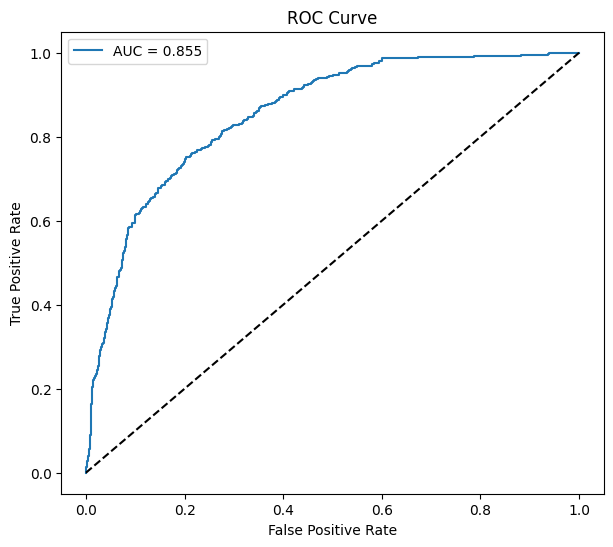

In [ ]:
y_true = test_metrics['y_true']
y_score = test_metrics['y_score']

fpr, tpr, _ = roc_curve(y_true, y_score)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

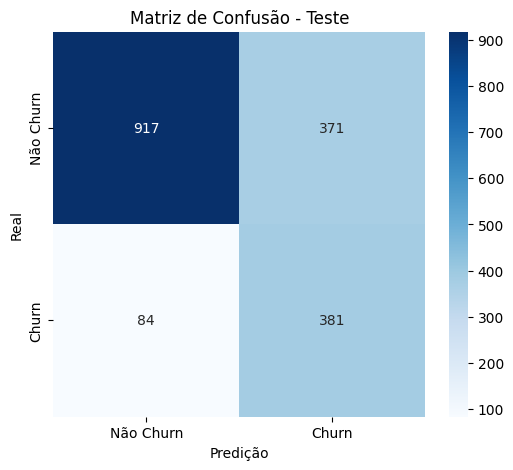

In [ ]:
# --- Confusion Matrix ---
cm = test_metrics["cm"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não Churn", "Churn"],
            yticklabels=["Não Churn", "Churn"])
plt.title("Matriz de Confusão - Teste")
plt.xlabel("Predição")
plt.ylabel("Real")
plt.show()

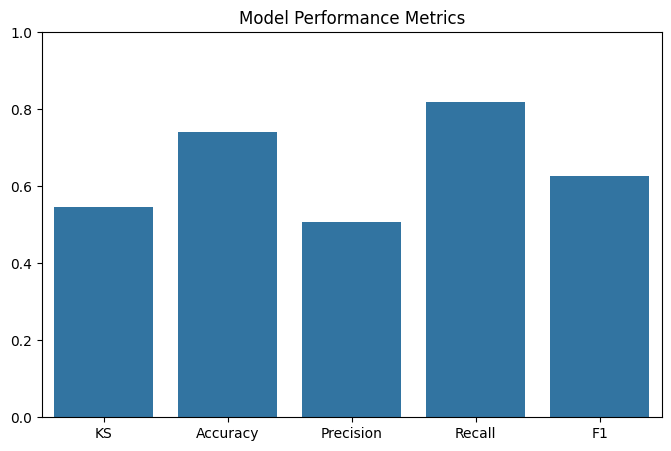

In [ ]:
metrics = ["KS", "Accuracy", "Precision", "Recall", "F1"]
values = [
    test_metrics['ks'],
    test_metrics['acc'],
    test_metrics['prec'],
    test_metrics['rec'],
    test_metrics['f1']
]
plt.figure(figsize=(8,5))
sns.barplot(x=metrics, y=values)
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.show()

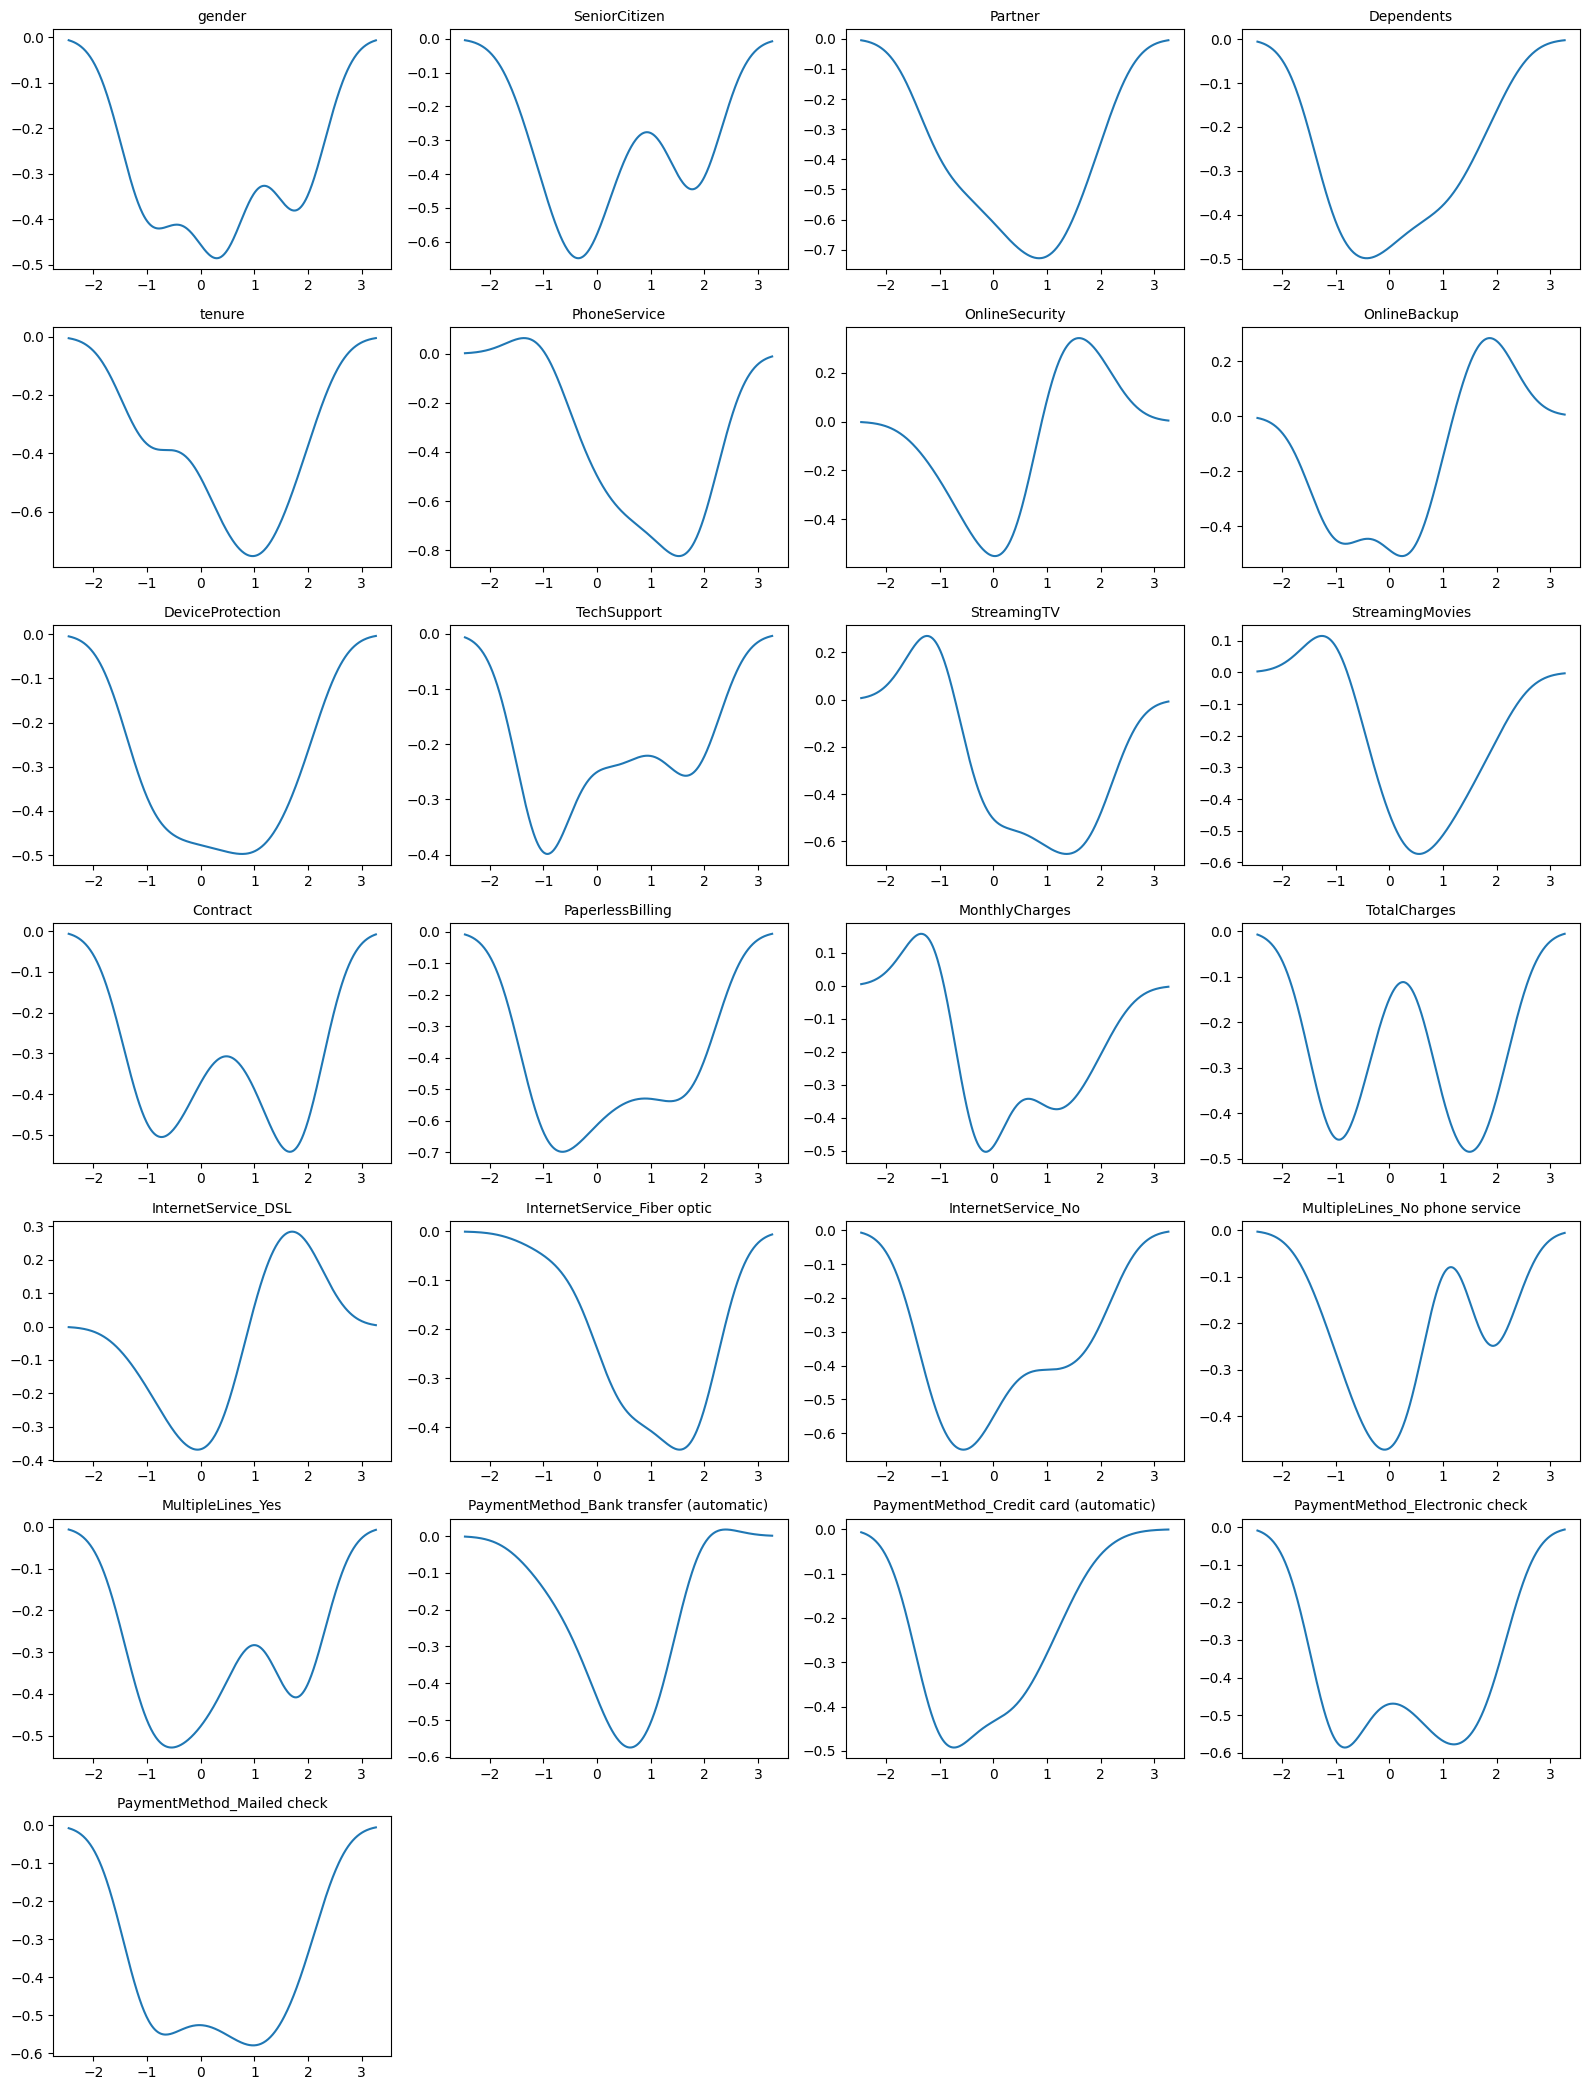

In [ ]:
# --- Visualize learned curves of first FastKANLayer ---
plot_all_feature_curves(model, feature_names)

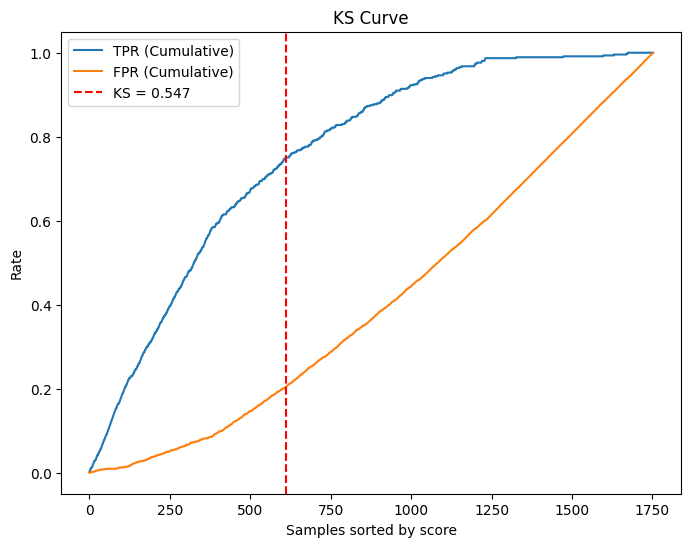

In [ ]:
y_true = test_metrics['y_true']
y_score = test_metrics['y_score']

# Ordenar por score decrescente
df = np.vstack([y_true, y_score]).T
df = df[np.argsort(df[:,1])[::-1]]

# TPR e FPR acumulados
positives = df[df[:,0] == 1]
negatives = df[df[:,0] == 0]

cum_tpr = np.cumsum(df[:,0]) / len(positives)
cum_fpr = np.cumsum(1 - df[:,0]) / len(negatives)

ks_stat = np.max(np.abs(cum_tpr - cum_fpr))
ks_pos = np.argmax(np.abs(cum_tpr - cum_fpr))

plt.figure(figsize=(8,6))
plt.plot(cum_tpr, label="TPR (Cumulative)")
plt.plot(cum_fpr, label="FPR (Cumulative)")
plt.axvline(ks_pos, color="red", linestyle="--", label=f"KS = {ks_stat:.3f}")
plt.title("KS Curve")
plt.xlabel("Samples sorted by score")
plt.ylabel("Rate")
plt.legend()
plt.show()

# Experimento 3

In [ ]:
def ks_cumulative(y_true, y_score, plot=False, title="KS Curve"):
    """
    Calcula o KS estatístico a partir das curvas acumuladas
    de positivos e negativos ordenados pelo score.

    Retorna:
        ks_stat (float)
    """

    # Converter para arrays numpy
    y_true = np.asarray(y_true)
    y_score = np.asarray(y_score)

    # Ordenar scores de forma decrescente
    order = np.argsort(y_score)[::-1]
    y_true_sorted = y_true[order]

    # Quantidade total de positivos e negativos
    n_pos = np.sum(y_true_sorted == 1)
    n_neg = np.sum(y_true_sorted == 0)

    # Evitar divisão por zero
    if n_pos == 0 or n_neg == 0:
        return 0.0

    # Curvas acumuladas
    cum_pos = np.cumsum(y_true_sorted == 1) / n_pos
    cum_neg = np.cumsum(y_true_sorted == 0) / n_neg

    # KS
    ks_values = np.abs(cum_pos - cum_neg)
    ks_stat = np.max(ks_values)
    ks_pos = np.argmax(ks_values)

    if plot:
        plt.figure(figsize=(8, 6))
        plt.plot(cum_pos, label="TPR (Cumulativo)")
        plt.plot(cum_neg, label="FPR (Cumulativo)")
        plt.axvline(
            ks_pos,
            color="red",
            linestyle="--",
            label=f"KS = {ks_stat:.3f}"
        )
        plt.xlabel("Amostras ordenadas pelo score")
        plt.ylabel("Taxa acumulada")
        plt.title(f"Curva KS")
        plt.legend()
        plt.grid(True)
        plt.show()



    return ks_stat

In [ ]:
EXPERIMENTS = {
    "arch": {
        "vary": ["n_layers", "hidden_size"],
        "fixed": {
            "num_grids": 8,
            "grid_min": -1,
            "grid_max": 1,
            "lr": 1e-3,
            "weight_decay": 1e-6
        }
    },
    "spline": {
        "vary": ["num_grids", "grid_range"],
        "fixed": {
            "n_layers": 2,
            "hidden_size_0": 64,
            "hidden_size_1": 32,
            "lr": 1e-3,
            "weight_decay": 1e-6
        }
    }
}


In [ ]:
def objective_factory(experiment_name, fixed_params):

    def objective(trial):

        input_dim = X_train_over.shape[1]
        device = "cuda" if torch.cuda.is_available() else "cpu"

        # ---------- arquitetura ----------
        if "n_layers" in fixed_params:
            n_layers = fixed_params["n_layers"]
        else:
            n_layers = trial.suggest_int("n_layers", 1, 4)

        layers = [input_dim]
        for i in range(n_layers):
            key = f"hidden_size_{i}"
            if key in fixed_params:
                h = fixed_params[key]
            else:
                h = trial.suggest_int(key, 16, 256, log=True)
            layers.append(h)
        layers.append(1)

        # ---------- spline ----------
        num_grids = fixed_params.get(
            "num_grids",
            trial.suggest_int("num_grids", 4, 16)
        )

        grid_min = fixed_params.get(
            "grid_min",
            trial.suggest_float("grid_min", -3, 0)
        )

        grid_max = fixed_params.get(
            "grid_max",
            trial.suggest_float("grid_max", 0, 3)
        )

        # ---------- otimização ----------
        lr = fixed_params.get(
            "lr",
            trial.suggest_float("lr", 1e-5, 5e-2, log=True)
        )

        weight_decay = fixed_params.get(
            "weight_decay",
            trial.suggest_float("weight_decay", 1e-8, 1e-3, log=True)
        )

        model = FastKAN(
            layers_hidden=layers,
            num_grids=num_grids,
            grid_min=grid_min,
            grid_max=grid_max
        ).to(device)

        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.BCEWithLogitsLoss()

        best_ks = -1
        patience = 10
        ctr = 0

        for epoch in range(1):
            model.train()
            for Xb, yb in train_dl:
                Xb, yb = Xb.to(device), yb.to(device)
                optimizer.zero_grad()
                loss = criterion(model(Xb).squeeze(-1), yb)
                loss.backward()
                optimizer.step()

            val = evaluate_model(model, val_dl, device)
            ks = val["ks"]

            trial.report(ks, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

            if ks > best_ks:
                best_ks = ks
                ctr = 0
            else:
                ctr += 1

            if ctr >= patience:
                break

        return best_ks

    return objective


In [ ]:
exp_cfg = EXPERIMENTS["arch"]

study = optuna.create_study(direction="maximize")
study.optimize(
    objective_factory("arch", exp_cfg["fixed"]),
    n_trials=30
)

print("Best KS:", study.best_value)
print("Params:", study.best_params)


[I 2025-12-19 14:19:16,866] A new study created in memory with name: no-name-5284ace5-7f9b-4172-86d4-22ab0ba2dfca
[I 2025-12-19 14:19:24,591] Trial 0 finished with value: 0.3478260869565218 and parameters: {'n_layers': 2, 'hidden_size_0': 39, 'hidden_size_1': 38, 'num_grids': 11, 'grid_min': -1.8397500694164148, 'grid_max': 2.624874475964881, 'lr': 7.56346616971118e-05, 'weight_decay': 0.0007780357994601455}. Best is trial 0 with value: 0.3478260869565218.
[I 2025-12-19 14:19:26,492] Trial 1 finished with value: 0.24844720496894418 and parameters: {'n_layers': 3, 'hidden_size_0': 137, 'hidden_size_1': 34, 'hidden_size_2': 232, 'num_grids': 13, 'grid_min': -1.9263777388140442, 'grid_max': 2.775465244942175, 'lr': 1.2885009847069662e-05, 'weight_decay': 9.67731701619816e-07}. Best is trial 0 with value: 0.3478260869565218.
[I 2025-12-19 14:19:27,022] Trial 2 finished with value: 0.4736024844720497 and parameters: {'n_layers': 1, 'hidden_size_0': 41, 'num_grids': 15, 'grid_min': -2.831063

Best KS: 0.4976708074534161
Params: {'n_layers': 1, 'hidden_size_0': 72, 'num_grids': 13, 'grid_min': -0.9171870457592859, 'grid_max': 0.09450887963138255, 'lr': 2.935054904652755e-05, 'weight_decay': 3.470063282162304e-05}


In [ ]:
all_results = []

for trial in study.trials:
    all_results.append({
        "ks": trial.value,
        **trial.params
    })

results_df = pd.DataFrame(all_results)


In [ ]:
def plot_diagnostics(y_true, y_prob, title_prefix=""):

    # ─── ROC ─────────────────────────────────────────────
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_score = roc_auc_score(y_true, y_prob)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"{title_prefix} – ROC Curve")
    plt.legend()
    plt.show()

    # ─── KS ──────────────────────────────────────────────
    ks = ks_cumulative(y_true, y_prob, plot=True,
                       title=f"{title_prefix} – KS Curve")

    # ─── Confusion Matrix ────────────────────────────────
    y_pred = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Não Churn", "Churn"],
                yticklabels=["Não Churn", "Churn"])
    plt.title(f"{title_prefix} – Confusion Matrix")
    plt.xlabel("Predição")
    plt.ylabel("Real")
    plt.show()

    return {"ks": ks, "auc": auc_score}


[I 2025-12-19 14:34:40,829] A new study created in memory with name: no-name-d7fa8200-01cd-406d-b0b4-81e1b8ebf8ad



===== Experimento KAN | n_layers = 1 =====


[I 2025-12-19 14:34:43,045] Trial 0 finished with value: 0.052018633540372616 and parameters: {'hidden_size_0': 30, 'num_grids': 16, 'grid_min': -0.7301085759356614, 'grid_max': 0.7727779563362988, 'lr': 2.8119185053606915e-05, 'weight_decay': 5.92559827538193e-06}. Best is trial 0 with value: 0.052018633540372616.
[I 2025-12-19 14:34:43,849] Trial 1 finished with value: 0.1172360248447204 and parameters: {'hidden_size_0': 25, 'num_grids': 5, 'grid_min': -1.8188647153583841, 'grid_max': 2.0068838201786194, 'lr': 5.780401049199867e-05, 'weight_decay': 0.00013956142206780376}. Best is trial 1 with value: 0.1172360248447204.
[I 2025-12-19 14:34:45,688] Trial 2 finished with value: 0.08695652173913043 and parameters: {'hidden_size_0': 47, 'num_grids': 15, 'grid_min': -0.07665481804407115, 'grid_max': 0.9706251469516324, 'lr': 1.584709255715047e-05, 'weight_decay': 3.0335952914640377e-05}. Best is trial 1 with value: 0.1172360248447204.
[I 2025-12-19 14:34:47,226] Trial 3 finished with valu

Ep 001 | train_loss 0.5497 | val_loss 0.4990 | val_auc 0.8454 | val_ks 0.5489 | prec 0.708 | rec 0.894 | f1 0.790
Ep 002 | train_loss 0.5057 | val_loss 0.5019 | val_auc 0.8402 | val_ks 0.5427 | prec 0.776 | rec 0.736 | f1 0.755
Ep 003 | train_loss 0.4852 | val_loss 0.5110 | val_auc 0.8464 | val_ks 0.5396 | prec 0.799 | rec 0.693 | f1 0.742
Ep 004 | train_loss 0.4896 | val_loss 0.4846 | val_auc 0.8516 | val_ks 0.5637 | prec 0.730 | rec 0.880 | f1 0.798
Ep 005 | train_loss 0.4711 | val_loss 0.5081 | val_auc 0.8394 | val_ks 0.5357 | prec 0.787 | rec 0.727 | f1 0.755
Ep 006 | train_loss 0.4558 | val_loss 0.5169 | val_auc 0.8345 | val_ks 0.5233 | prec 0.754 | rec 0.741 | f1 0.747
Ep 007 | train_loss 0.4584 | val_loss 0.5166 | val_auc 0.8341 | val_ks 0.5334 | prec 0.751 | rec 0.792 | f1 0.771
Ep 008 | train_loss 0.4514 | val_loss 0.5354 | val_auc 0.8175 | val_ks 0.5093 | prec 0.688 | rec 0.892 | f1 0.777
Ep 009 | train_loss 0.4410 | val_loss 0.5154 | val_auc 0.8394 | val_ks 0.5481 | prec 0.7

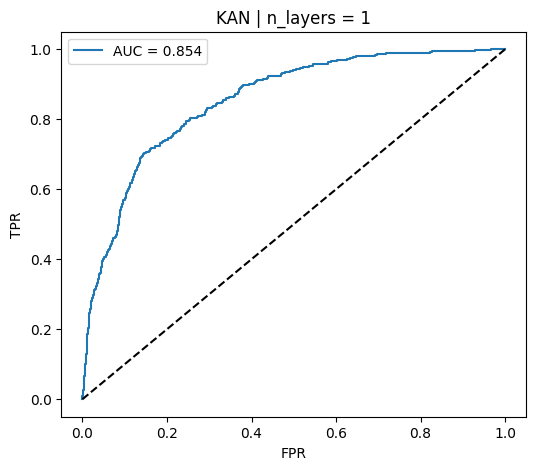

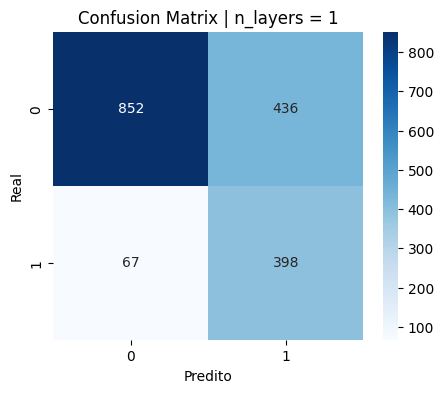

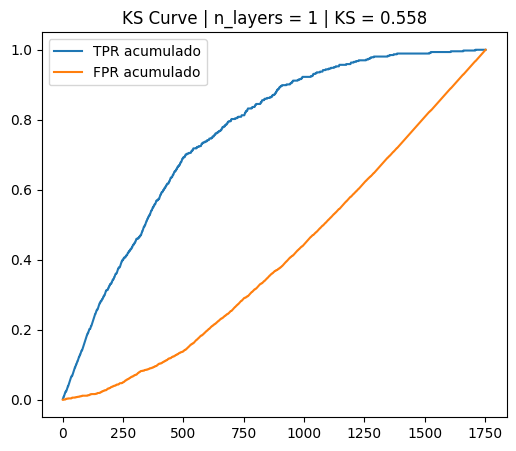

[I 2025-12-19 14:34:57,740] A new study created in memory with name: no-name-5801e232-86f4-48d7-9e61-b541c87ecdd6



===== Experimento KAN | n_layers = 2 =====


[I 2025-12-19 14:34:59,867] Trial 0 finished with value: 0.09083850931677023 and parameters: {'hidden_size_0': 33, 'hidden_size_1': 243, 'num_grids': 9, 'grid_min': -0.22768262571756726, 'grid_max': 1.7478751660446203, 'lr': 0.00011424433101479392, 'weight_decay': 0.000494272438995118}. Best is trial 0 with value: 0.09083850931677023.
[I 2025-12-19 14:35:01,631] Trial 1 finished with value: 0.15527950310559008 and parameters: {'hidden_size_0': 28, 'hidden_size_1': 114, 'num_grids': 16, 'grid_min': -1.4487724855220239, 'grid_max': 2.432814933651869, 'lr': 0.00019035922563278958, 'weight_decay': 2.5981102059737964e-08}. Best is trial 1 with value: 0.15527950310559008.
[I 2025-12-19 14:35:02,288] Trial 2 finished with value: 0.14906832298136646 and parameters: {'hidden_size_0': 21, 'hidden_size_1': 31, 'num_grids': 9, 'grid_min': -0.44463382807462093, 'grid_max': 0.5928360537700428, 'lr': 0.0037087567835405546, 'weight_decay': 1.1882499931002718e-07}. Best is trial 1 with value: 0.1552795

Ep 001 | train_loss 0.7862 | val_loss 0.4990 | val_auc 0.8426 | val_ks 0.5334 | prec 0.768 | rec 0.759 | f1 0.764
Ep 002 | train_loss 0.4899 | val_loss 0.5141 | val_auc 0.8468 | val_ks 0.5396 | prec 0.681 | rec 0.922 | f1 0.783
Ep 003 | train_loss 0.4747 | val_loss 0.5109 | val_auc 0.8367 | val_ks 0.5256 | prec 0.744 | rec 0.776 | f1 0.760
Ep 004 | train_loss 0.4536 | val_loss 0.5238 | val_auc 0.8404 | val_ks 0.5419 | prec 0.687 | rec 0.900 | f1 0.779
Ep 005 | train_loss 0.4663 | val_loss 0.5786 | val_auc 0.8262 | val_ks 0.5031 | prec 0.652 | rec 0.932 | f1 0.767
Ep 006 | train_loss 0.4645 | val_loss 0.5522 | val_auc 0.8364 | val_ks 0.5311 | prec 0.743 | rec 0.809 | f1 0.774
Ep 007 | train_loss 0.4363 | val_loss 0.5757 | val_auc 0.8326 | val_ks 0.5474 | prec 0.787 | rec 0.743 | f1 0.764
Ep 008 | train_loss 0.4111 | val_loss 0.5463 | val_auc 0.8244 | val_ks 0.5179 | prec 0.706 | rec 0.832 | f1 0.764
Ep 009 | train_loss 0.3836 | val_loss 0.6729 | val_auc 0.8232 | val_ks 0.5217 | prec 0.7

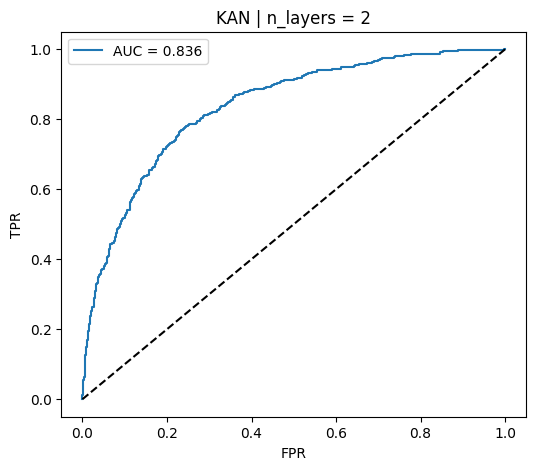

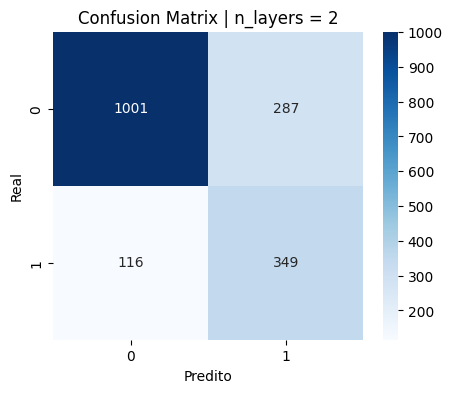

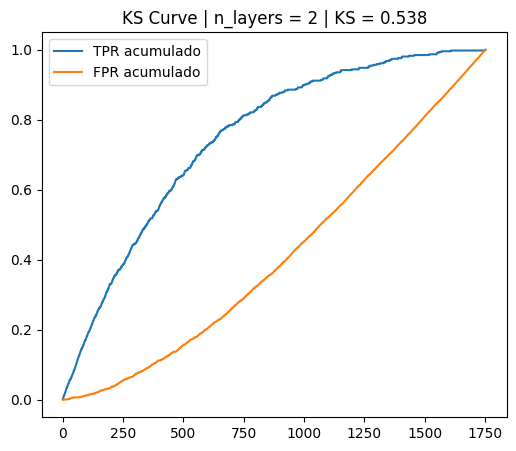

[I 2025-12-19 14:35:42,938] A new study created in memory with name: no-name-67a085f7-14a3-4bbb-8fab-a2b89cf1dcd8



===== Experimento KAN | n_layers = 3 =====


[I 2025-12-19 14:35:45,317] Trial 0 finished with value: 0.24767080745341616 and parameters: {'hidden_size_0': 19, 'hidden_size_1': 106, 'hidden_size_2': 218, 'num_grids': 12, 'grid_min': -2.88815308506394, 'grid_max': 1.8921221970891047, 'lr': 0.0001627498424552686, 'weight_decay': 0.0005216503116719553}. Best is trial 0 with value: 0.24767080745341616.
[I 2025-12-19 14:35:46,308] Trial 1 finished with value: 0.05900621118012425 and parameters: {'hidden_size_0': 23, 'hidden_size_1': 33, 'hidden_size_2': 17, 'num_grids': 11, 'grid_min': -0.3462181240872302, 'grid_max': 0.5800438151345596, 'lr': 0.002344849069733785, 'weight_decay': 3.8301508095920573e-05}. Best is trial 0 with value: 0.24767080745341616.
[I 2025-12-19 14:35:55,246] Trial 2 finished with value: 0.045031055900621175 and parameters: {'hidden_size_0': 20, 'hidden_size_1': 147, 'hidden_size_2': 159, 'num_grids': 16, 'grid_min': -2.8128110647741806, 'grid_max': 1.254110656003546, 'lr': 1.0681058870462848e-05, 'weight_decay':

Ep 001 | train_loss 1.1605 | val_loss 0.5378 | val_auc 0.8311 | val_ks 0.5264 | prec 0.779 | rec 0.689 | f1 0.731
Ep 002 | train_loss 0.5214 | val_loss 0.7826 | val_auc 0.8167 | val_ks 0.5194 | prec 0.590 | rec 0.983 | f1 0.737
Ep 003 | train_loss 0.4992 | val_loss 0.5329 | val_auc 0.8394 | val_ks 0.5349 | prec 0.753 | rec 0.775 | f1 0.764
Ep 004 | train_loss 0.4755 | val_loss 0.5468 | val_auc 0.8223 | val_ks 0.4992 | prec 0.675 | rec 0.885 | f1 0.766
Ep 005 | train_loss 0.4337 | val_loss 0.6462 | val_auc 0.8252 | val_ks 0.5217 | prec 0.812 | rec 0.466 | f1 0.592
Ep 006 | train_loss 0.4175 | val_loss 0.6680 | val_auc 0.8320 | val_ks 0.5210 | prec 0.663 | rec 0.936 | f1 0.776
Ep 007 | train_loss 0.5362 | val_loss 0.5316 | val_auc 0.8386 | val_ks 0.5225 | prec 0.756 | rec 0.755 | f1 0.755
Ep 008 | train_loss 0.4134 | val_loss 0.7390 | val_auc 0.7985 | val_ks 0.5070 | prec 0.765 | rec 0.444 | f1 0.562
Early stopping triggered (patience reached).
Loaded best model from epoch 3
TEST:

train

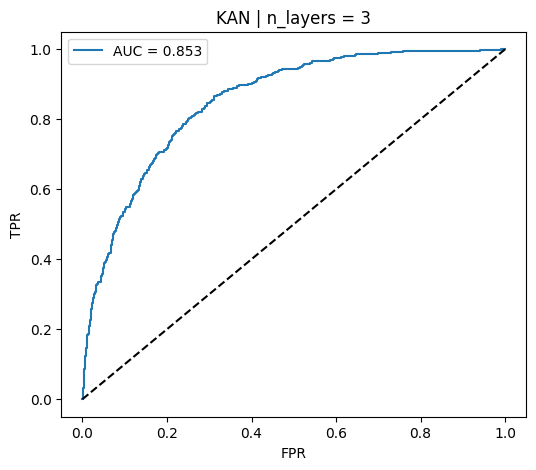

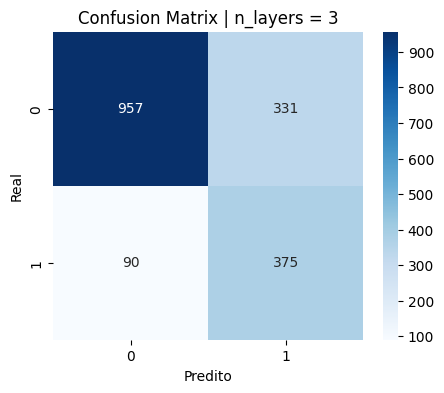

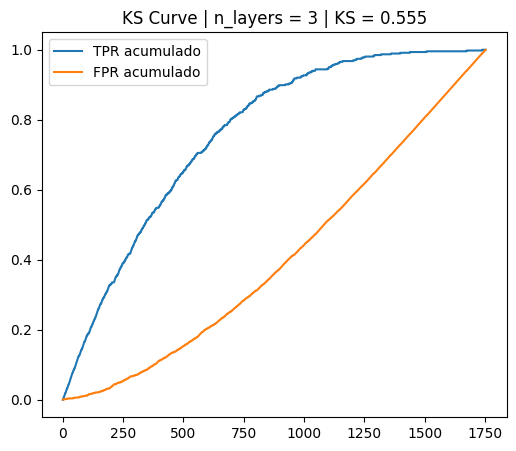

[I 2025-12-19 14:37:24,018] A new study created in memory with name: no-name-470e326c-a91c-4e77-962d-08c567ba3367



===== Experimento KAN | n_layers = 4 =====


[I 2025-12-19 14:37:24,767] Trial 0 finished with value: 0.5178571428571429 and parameters: {'hidden_size_0': 22, 'hidden_size_1': 180, 'hidden_size_2': 25, 'hidden_size_3': 234, 'num_grids': 5, 'grid_min': -2.7831845079044077, 'grid_max': 2.1085360096213845, 'lr': 0.001939345806977751, 'weight_decay': 0.00016070086122083014}. Best is trial 0 with value: 0.5178571428571429.
[I 2025-12-19 14:37:38,323] Trial 1 finished with value: 0.0892857142857143 and parameters: {'hidden_size_0': 50, 'hidden_size_1': 33, 'hidden_size_2': 153, 'hidden_size_3': 220, 'num_grids': 14, 'grid_min': -0.5866598063553328, 'grid_max': 1.0799632740645086, 'lr': 0.005945276931139666, 'weight_decay': 8.855479981932184e-08}. Best is trial 0 with value: 0.5178571428571429.
[I 2025-12-19 14:37:39,265] Trial 2 finished with value: 0.44487577639751547 and parameters: {'hidden_size_0': 16, 'hidden_size_1': 30, 'hidden_size_2': 224, 'hidden_size_3': 199, 'num_grids': 5, 'grid_min': -1.719769050005632, 'grid_max': 1.8346

Ep 001 | train_loss 0.5312 | val_loss 0.4864 | val_auc 0.8463 | val_ks 0.5559 | prec 0.726 | rec 0.845 | f1 0.781
Ep 002 | train_loss 0.4720 | val_loss 0.4892 | val_auc 0.8453 | val_ks 0.5505 | prec 0.775 | rec 0.759 | f1 0.767
Ep 003 | train_loss 0.4523 | val_loss 0.4999 | val_auc 0.8417 | val_ks 0.5365 | prec 0.776 | rec 0.734 | f1 0.754
Ep 004 | train_loss 0.4195 | val_loss 0.5344 | val_auc 0.8337 | val_ks 0.5248 | prec 0.787 | rec 0.633 | f1 0.702
Ep 005 | train_loss 0.3799 | val_loss 0.5257 | val_auc 0.8305 | val_ks 0.5054 | prec 0.767 | rec 0.700 | f1 0.732
Ep 006 | train_loss 0.3477 | val_loss 0.5282 | val_auc 0.8316 | val_ks 0.5109 | prec 0.744 | rec 0.752 | f1 0.748
Early stopping triggered (patience reached).
Loaded best model from epoch 1
TEST:

train_loss 0.3477 | val_loss 0.5282 | test_loss 0.5274 | val_auc 0.8491 | test_ks 0.5109 | prec 0.483 | rec 0.845 | f1 0.615


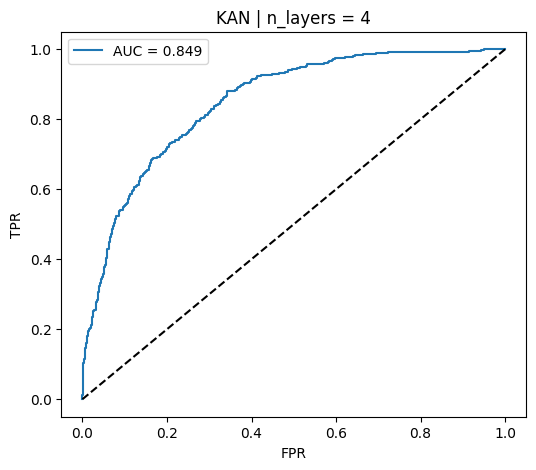

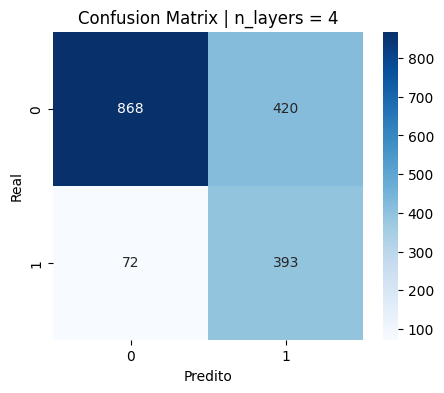

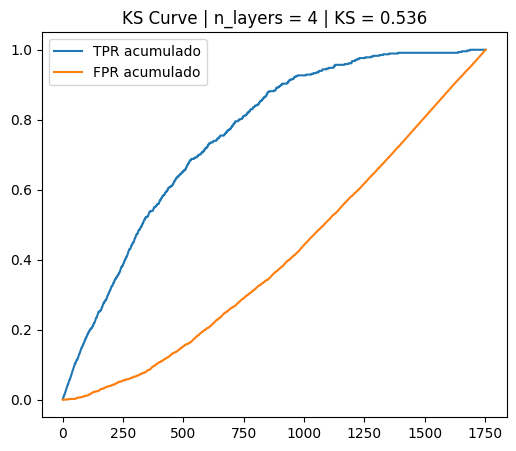

,n_layers,ks,auc
0,1,0.558218,0.853548
1,2,0.537750,0.836472
2,3,0.554555,0.852586
3,4,0.536402,0.849130


In [ ]:
N_LAYERS = [1, 2, 3, 4]
summary = []

for n_layers in N_LAYERS:

    print(f"\n===== Experimento KAN | n_layers = {n_layers} =====")

    fixed_params = {
        "n_layers": n_layers
    }

    study = optuna.create_study(direction="maximize")
    study.optimize(
        objective_factory(
            experiment_name=f"KAN_n_layers_{n_layers}",
            fixed_params=fixed_params
        ),
        n_trials=15
    )

    best_params = {**fixed_params, **study.best_params}

    # ─── Reconstrói arquitetura final ─────────────────────────
    input_dim = X_train_over.shape[1]

    layers = [input_dim]
    for i in range(best_params["n_layers"]):
        layers.append(best_params[f"hidden_size_{i}"])
    layers.append(1)

    model = FastKAN(
        layers_hidden=layers,
        num_grids=best_params["num_grids"],
        grid_min=best_params["grid_min"],
        grid_max=best_params["grid_max"]
    )

    # ─── Treino final ─────────────────────────────────────────
    model, history, test_metrics = train_fastkan(
        model,
        train_dl,
        val_dl,
        test_dl,
        device="cuda",
        epochs=25,
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"],
        patience=5
    )

    y_true = test_metrics["y_true"]
    y_score = test_metrics["y_score"]

    # ─── ROC ─────────────────────────────────────────
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
    plt.plot([0,1], [0,1], "k--")
    plt.title(f"KAN | n_layers = {n_layers}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()

    # ─── Matriz de Confusão ─────────────────────────
    y_pred = (y_score >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix | n_layers = {n_layers}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # ─── KS Curve ───────────────────────────────────
    order = np.argsort(y_score)[::-1]
    y_sorted = y_true[order]

    cum_tpr = np.cumsum(y_sorted) / y_sorted.sum()
    cum_fpr = np.cumsum(1 - y_sorted) / (len(y_sorted) - y_sorted.sum())

    ks = np.max(np.abs(cum_tpr - cum_fpr))

    plt.figure(figsize=(6,5))
    plt.plot(cum_tpr, label="TPR acumulado")
    plt.plot(cum_fpr, label="FPR acumulado")
    plt.title(f"KS Curve | n_layers = {n_layers} | KS = {ks:.3f}")
    plt.legend()
    plt.show()

    # ─── Summary ────────────────────────────────────
    summary.append({
        "n_layers": n_layers,
        "ks": ks,
        "auc": auc_score
    })

summary_df = pd.DataFrame(summary)
summary_df


In [ ]:
def ks_curve(y_true, y_score, title="KS Curve"):
    order = np.argsort(y_score)[::-1]
    y_sorted = y_true[order]

    n_pos = y_sorted.sum()
    n_neg = len(y_sorted) - n_pos

    cum_tpr = np.cumsum(y_sorted) / n_pos
    cum_fpr = np.cumsum(1 - y_sorted) / n_neg

    ks = np.max(np.abs(cum_tpr - cum_fpr))
    ks_pos = np.argmax(np.abs(cum_tpr - cum_fpr))

    plt.figure(figsize=(6,5))
    plt.plot(cum_tpr, label="TPR acumulado")
    plt.plot(cum_fpr, label="FPR acumulado")
    plt.axvline(ks_pos, linestyle="--", label=f"KS = {ks:.3f}")
    plt.title(title)
    plt.legend()
    plt.show()

    return ks


In [ ]:
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
    plt.plot([0,1],[0,1],"k--")
    plt.title(title)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()

    return auc_score


In [ ]:
def plot_confusion(y_true, y_score, threshold=0.5, title="Confusion Matrix"):
    y_pred = (y_score >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(title)
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()


In [ ]:
N_LAYERS = [1, 2, 3, 4]
summary = []

for n_layers in N_LAYERS:

    print(f"\n===== Experimento KAN | n_layers = {n_layers} =====")

    # ─── 1. FIXA PARÂMETRO ─────────────────────────────
    fixed_params = {
        "n_layers": n_layers
    }

    # ─── 2. OPTUNA ─────────────────────────────────────
    study = optuna.create_study(direction="maximize")
    study.optimize(
        objective_factory(
            experiment_name=f"KAN_n_layers_{n_layers}",
            fixed_params=fixed_params
        ),
        n_trials=15
    )

    best_params = {**fixed_params, **study.best_params}

    # ─── 3. RECONSTRÓI MODELO FINAL ────────────────────
    input_dim = X_train_over.shape[1]

    layers = [input_dim]
    for i in range(best_params["n_layers"]):
        layers.append(best_params[f"hidden_size_{i}"])
    layers.append(1)

    model = FastKAN(
        layers_hidden=layers,
        num_grids=best_params["num_grids"],
        grid_min=best_params["grid_min"],
        grid_max=best_params["grid_max"]
    )

    # ─── 4. TREINO FINAL COMPLETO ──────────────────────
    model, history, test_metrics = train_fastkan(
        model,
        train_dl,
        val_dl,
        test_dl,
        device="cuda",
        epochs=40,
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"],
        patience=8
    )

    y_true = test_metrics["y_true"]
    y_score = test_metrics["y_score"]

    # ─── 5. GRÁFICOS ───────────────────────────────────
    auc_score = plot_roc_curve(
        y_true,
        y_score,
        title=f"KAN | n_layers = {n_layers}"
    )

    ks_score = ks_curve(
        y_true,
        y_score,
        title=f"KS Curve | n_layers = {n_layers}"
    )

    plot_confusion(
        y_true,
        y_score,
        title=f"Confusion Matrix | n_layers = {n_layers}"
    )

    # ─── 6. SUMMARY ────────────────────────────────────
    summary.append({
        "n_layers": n_layers,
        "ks": ks_score,
        "auc": auc_score
    })

    summary_df = pd.DataFrame(summary)
    summary_df


[I 2025-12-19 14:54:27,101] A new study created in memory with name: no-name-335ad05a-e44d-4e33-85a0-e1ce48fc941e



===== Experimento KAN | num_grids = 4 =====


[I 2025-12-19 14:54:27,518] Trial 0 finished with value: 0.25465838509316774 and parameters: {'n_layers': 3, 'hidden_size_0': 46, 'hidden_size_1': 56, 'hidden_size_2': 56, 'num_grids': 6, 'grid_min': -2.0595164451668584, 'grid_max': 2.6076976717759504, 'lr': 2.275774194953938e-05, 'weight_decay': 0.0008819524044859261}. Best is trial 0 with value: 0.25465838509316774.
[I 2025-12-19 14:54:28,095] Trial 1 finished with value: 0.5364906832298136 and parameters: {'n_layers': 4, 'hidden_size_0': 97, 'hidden_size_1': 105, 'hidden_size_2': 25, 'hidden_size_3': 52, 'num_grids': 16, 'grid_min': -2.0483701734140296, 'grid_max': 2.9352929213984096, 'lr': 0.0007414479202137432, 'weight_decay': 6.04297332206394e-06}. Best is trial 1 with value: 0.5364906832298136.
[I 2025-12-19 14:54:28,410] Trial 2 finished with value: 0.11723602484472051 and parameters: {'n_layers': 2, 'hidden_size_0': 31, 'hidden_size_1': 49, 'num_grids': 8, 'grid_min': -1.8821993910956116, 'grid_max': 2.99110793245797, 'lr': 2.

Ep 001 | train_loss 0.5470 | val_loss 0.4841 | val_auc 0.8464 | val_ks 0.5443 | prec 0.736 | rec 0.837 | f1 0.783
Ep 002 | train_loss 0.4836 | val_loss 0.5235 | val_auc 0.8312 | val_ks 0.5489 | prec 0.784 | rec 0.741 | f1 0.762
Ep 003 | train_loss 0.4889 | val_loss 0.5173 | val_auc 0.8404 | val_ks 0.5536 | prec 0.786 | rec 0.653 | f1 0.713
Ep 004 | train_loss 0.4896 | val_loss 0.5299 | val_auc 0.8313 | val_ks 0.5171 | prec 0.779 | rec 0.688 | f1 0.731
Ep 005 | train_loss 0.4788 | val_loss 0.5251 | val_auc 0.8381 | val_ks 0.5225 | prec 0.778 | rec 0.703 | f1 0.739
Ep 006 | train_loss 0.4736 | val_loss 0.4993 | val_auc 0.8442 | val_ks 0.5551 | prec 0.732 | rec 0.841 | f1 0.783
Ep 007 | train_loss 0.4661 | val_loss 0.5431 | val_auc 0.8214 | val_ks 0.4953 | prec 0.786 | rec 0.585 | f1 0.671
Ep 008 | train_loss 0.4818 | val_loss 0.5019 | val_auc 0.8416 | val_ks 0.5551 | prec 0.752 | rec 0.797 | f1 0.774
Ep 009 | train_loss 0.4687 | val_loss 0.4977 | val_auc 0.8413 | val_ks 0.5404 | prec 0.7

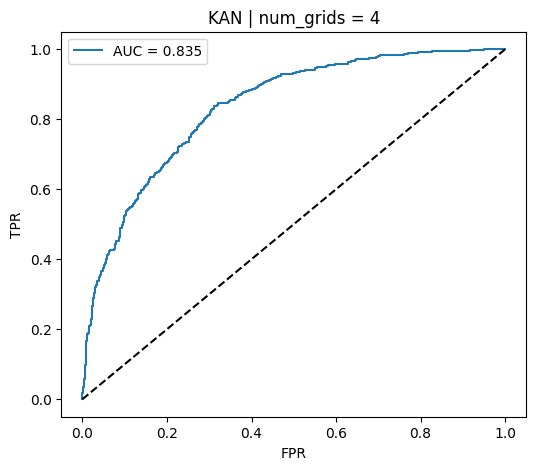

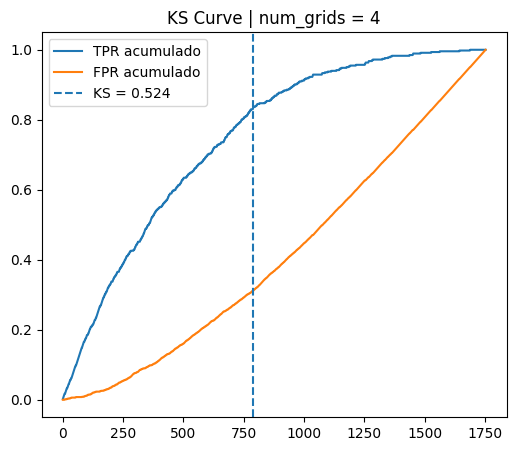

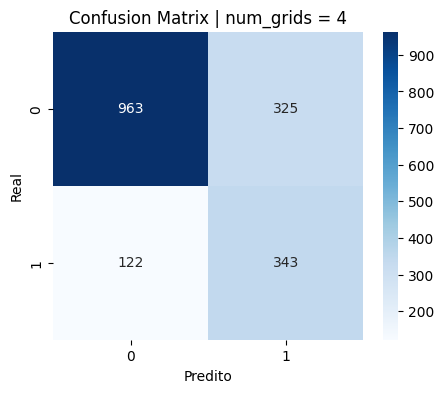

[I 2025-12-19 14:54:47,334] A new study created in memory with name: no-name-a45074f3-2a17-4d26-aaca-9245661c13f8



===== Experimento KAN | num_grids = 8 =====


[I 2025-12-19 14:54:49,534] Trial 0 finished with value: 0.06211180124223603 and parameters: {'n_layers': 3, 'hidden_size_0': 67, 'hidden_size_1': 219, 'hidden_size_2': 34, 'num_grids': 13, 'grid_min': -2.662768347152516, 'grid_max': 0.20280921465429091, 'lr': 2.184212462581824e-05, 'weight_decay': 2.7265665377807848e-05}. Best is trial 0 with value: 0.06211180124223603.
[I 2025-12-19 14:54:49,927] Trial 1 finished with value: 0.11723602484472051 and parameters: {'n_layers': 2, 'hidden_size_0': 28, 'hidden_size_1': 32, 'num_grids': 16, 'grid_min': -1.3462784483328347, 'grid_max': 0.8605614195771341, 'lr': 8.678890059323411e-05, 'weight_decay': 2.7245538260986867e-07}. Best is trial 1 with value: 0.11723602484472051.
[I 2025-12-19 14:54:50,329] Trial 2 finished with value: 0.5559006211180124 and parameters: {'n_layers': 2, 'hidden_size_0': 80, 'hidden_size_1': 31, 'num_grids': 16, 'grid_min': -2.369852514469477, 'grid_max': 2.025495823181985, 'lr': 0.002532303936648585, 'weight_decay': 

Ep 001 | train_loss 0.5634 | val_loss 0.5210 | val_auc 0.8268 | val_ks 0.5342 | prec 0.766 | rec 0.759 | f1 0.763
Ep 002 | train_loss 0.4292 | val_loss 0.5449 | val_auc 0.8269 | val_ks 0.5349 | prec 0.766 | rec 0.685 | f1 0.723
Ep 003 | train_loss 0.3513 | val_loss 0.5628 | val_auc 0.8257 | val_ks 0.5093 | prec 0.779 | rec 0.692 | f1 0.733
Ep 004 | train_loss 0.2963 | val_loss 0.6269 | val_auc 0.8141 | val_ks 0.5047 | prec 0.782 | rec 0.611 | f1 0.686
Ep 005 | train_loss 0.2552 | val_loss 0.6102 | val_auc 0.8141 | val_ks 0.4930 | prec 0.750 | rec 0.709 | f1 0.729
Ep 006 | train_loss 0.2326 | val_loss 0.7745 | val_auc 0.7971 | val_ks 0.4752 | prec 0.779 | rec 0.525 | f1 0.627
Ep 007 | train_loss 0.2176 | val_loss 0.7193 | val_auc 0.8061 | val_ks 0.4790 | prec 0.749 | rec 0.675 | f1 0.710
Ep 008 | train_loss 0.1940 | val_loss 0.8008 | val_auc 0.8012 | val_ks 0.4798 | prec 0.765 | rec 0.599 | f1 0.672
Ep 009 | train_loss 0.1670 | val_loss 0.8436 | val_auc 0.8011 | val_ks 0.4713 | prec 0.7

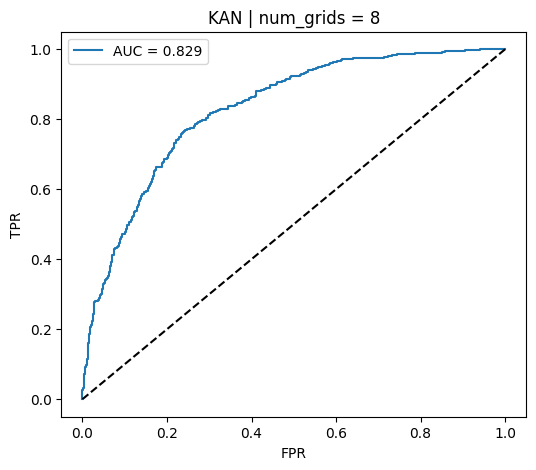

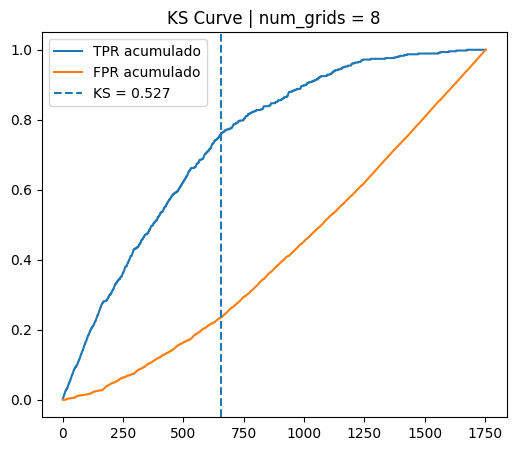

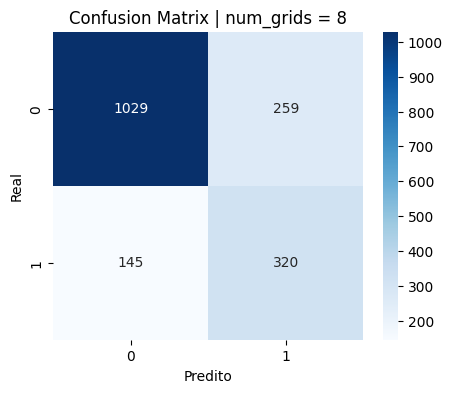

[I 2025-12-19 14:55:15,940] A new study created in memory with name: no-name-ebef4281-8013-423c-85ff-fec098f19050



===== Experimento KAN | num_grids = 12 =====


[I 2025-12-19 14:55:16,690] Trial 0 finished with value: 0.514751552795031 and parameters: {'n_layers': 1, 'hidden_size_0': 50, 'num_grids': 13, 'grid_min': -0.8280857742099448, 'grid_max': 2.525452056529818, 'lr': 0.0022191942622249803, 'weight_decay': 3.7387508038797006e-08}. Best is trial 0 with value: 0.514751552795031.
[I 2025-12-19 14:55:17,064] Trial 1 finished with value: 0.07375776397515521 and parameters: {'n_layers': 1, 'hidden_size_0': 16, 'num_grids': 15, 'grid_min': -2.148230469913776, 'grid_max': 0.46006876441088873, 'lr': 5.2721263955289035e-05, 'weight_decay': 7.575131927865679e-05}. Best is trial 0 with value: 0.514751552795031.
[I 2025-12-19 14:55:17,404] Trial 2 finished with value: 0.5318322981366459 and parameters: {'n_layers': 1, 'hidden_size_0': 27, 'num_grids': 13, 'grid_min': -2.204534204200954, 'grid_max': 2.38358200739053, 'lr': 0.005437501650494891, 'weight_decay': 0.00020298565013618331}. Best is trial 2 with value: 0.5318322981366459.
[I 2025-12-19 14:55:

Ep 001 | train_loss 0.5945 | val_loss 0.4996 | val_auc 0.8424 | val_ks 0.5326 | prec 0.763 | rec 0.755 | f1 0.759
Ep 002 | train_loss 0.4995 | val_loss 0.4993 | val_auc 0.8475 | val_ks 0.5590 | prec 0.686 | rec 0.921 | f1 0.786
Ep 003 | train_loss 0.5005 | val_loss 0.4933 | val_auc 0.8472 | val_ks 0.5543 | prec 0.789 | rec 0.731 | f1 0.759
Ep 004 | train_loss 0.4903 | val_loss 0.5009 | val_auc 0.8444 | val_ks 0.5528 | prec 0.731 | rec 0.854 | f1 0.788
Ep 005 | train_loss 0.4905 | val_loss 0.4878 | val_auc 0.8488 | val_ks 0.5675 | prec 0.773 | rec 0.791 | f1 0.782
Ep 006 | train_loss 0.4767 | val_loss 0.4933 | val_auc 0.8483 | val_ks 0.5722 | prec 0.756 | rec 0.823 | f1 0.788
Ep 007 | train_loss 0.4841 | val_loss 0.5129 | val_auc 0.8534 | val_ks 0.5699 | prec 0.689 | rec 0.920 | f1 0.788
Ep 008 | train_loss 0.4767 | val_loss 0.5012 | val_auc 0.8447 | val_ks 0.5497 | prec 0.754 | rec 0.804 | f1 0.778
Ep 009 | train_loss 0.4659 | val_loss 0.5034 | val_auc 0.8437 | val_ks 0.5435 | prec 0.7

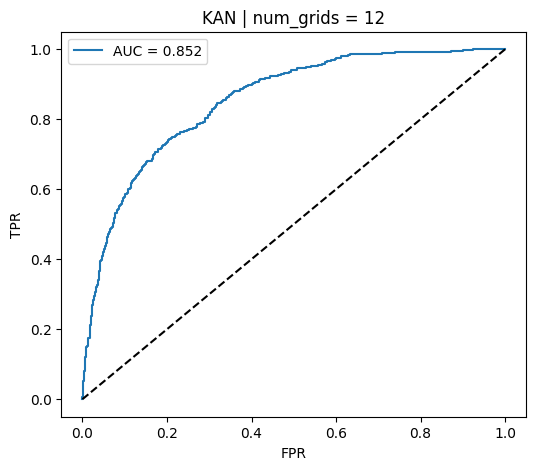

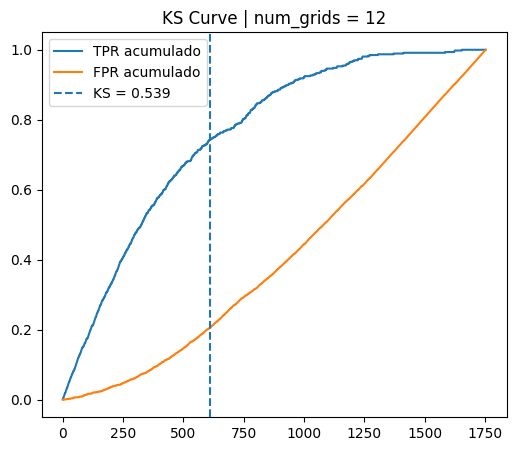

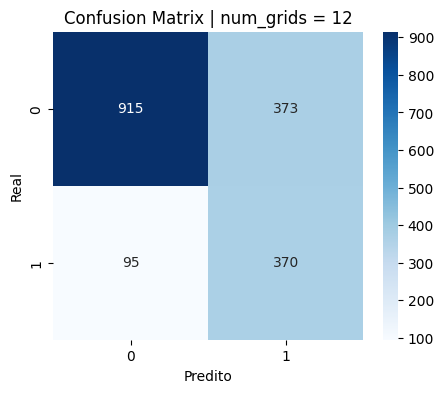

[I 2025-12-19 14:55:44,831] A new study created in memory with name: no-name-4d1b19e2-29de-412c-b939-c6ee566ab9ad



===== Experimento KAN | num_grids = 16 =====


[I 2025-12-19 14:55:46,557] Trial 0 finished with value: 0.08773291925465837 and parameters: {'n_layers': 2, 'hidden_size_0': 48, 'hidden_size_1': 57, 'num_grids': 4, 'grid_min': -0.3490357411322469, 'grid_max': 0.5996135750940395, 'lr': 0.00022595366517516556, 'weight_decay': 2.8031492232716415e-08}. Best is trial 0 with value: 0.08773291925465837.
[I 2025-12-19 14:55:49,383] Trial 1 finished with value: 0.05434782608695654 and parameters: {'n_layers': 3, 'hidden_size_0': 64, 'hidden_size_1': 20, 'hidden_size_2': 139, 'num_grids': 4, 'grid_min': -0.475685004757465, 'grid_max': 1.9217017885828513, 'lr': 0.00021540148564766937, 'weight_decay': 5.88056301891442e-05}. Best is trial 0 with value: 0.08773291925465837.
[I 2025-12-19 14:55:55,809] Trial 2 finished with value: 0.18866459627329196 and parameters: {'n_layers': 4, 'hidden_size_0': 53, 'hidden_size_1': 235, 'hidden_size_2': 21, 'hidden_size_3': 64, 'num_grids': 14, 'grid_min': -1.9905577506533376, 'grid_max': 1.7229166704395587, '

Ep 001 | train_loss 2.1461 | val_loss 0.5184 | val_auc 0.8458 | val_ks 0.5474 | prec 0.776 | rec 0.757 | f1 0.766
Ep 002 | train_loss 0.5582 | val_loss 0.5752 | val_auc 0.8425 | val_ks 0.5411 | prec 0.840 | rec 0.529 | f1 0.649
Ep 003 | train_loss 0.5331 | val_loss 0.5428 | val_auc 0.8486 | val_ks 0.5551 | prec 0.686 | rec 0.919 | f1 0.785
Ep 004 | train_loss 1.4334 | val_loss 0.5677 | val_auc 0.8381 | val_ks 0.5280 | prec 0.679 | rec 0.905 | f1 0.776
Ep 005 | train_loss 0.5380 | val_loss 0.5163 | val_auc 0.8445 | val_ks 0.5520 | prec 0.809 | rec 0.668 | f1 0.732
Ep 006 | train_loss 0.5183 | val_loss 0.5146 | val_auc 0.8484 | val_ks 0.5520 | prec 0.799 | rec 0.663 | f1 0.725
Ep 007 | train_loss 0.5212 | val_loss 0.4827 | val_auc 0.8494 | val_ks 0.5582 | prec 0.736 | rec 0.852 | f1 0.790
Ep 008 | train_loss 0.5480 | val_loss 0.4952 | val_auc 0.8472 | val_ks 0.5528 | prec 0.792 | rec 0.707 | f1 0.747
Ep 009 | train_loss 0.5217 | val_loss 0.5729 | val_auc 0.8495 | val_ks 0.5668 | prec 0.6

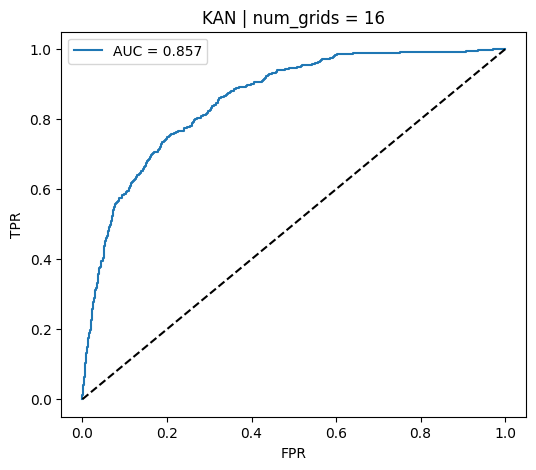

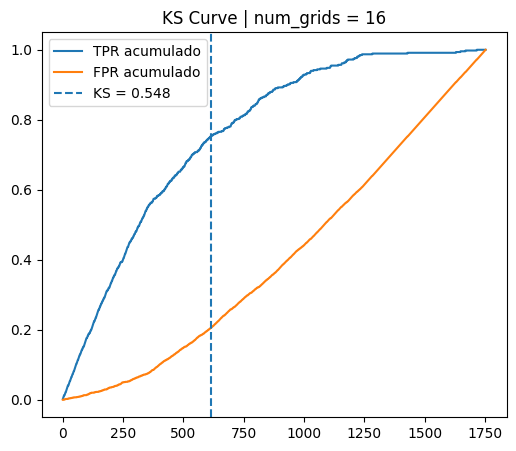

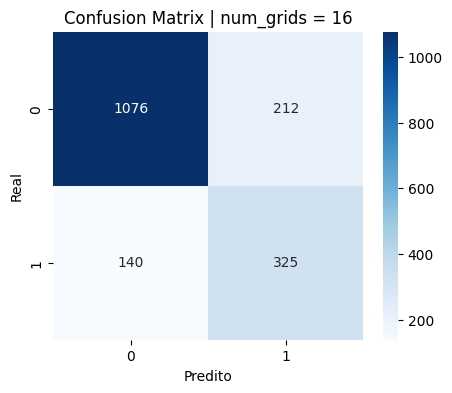

In [ ]:
NUM_GRIDS = [4, 8, 12, 16]
summary = []

for num_grids in NUM_GRIDS:

    print(f"\n===== Experimento KAN | num_grids = {num_grids} =====")

    # ─── 1. FIXA PARÂMETRO ─────────────────────────────
    fixed_params = {
        "num_grids": num_grids
    }

    # ─── 2. OPTUNA ─────────────────────────────────────
    study = optuna.create_study(direction="maximize")
    study.optimize(
        objective_factory(
            experiment_name=f"KAN_num_grids_{num_grids}",
            fixed_params=fixed_params
        ),
        n_trials=15
    )

    best_params = {**fixed_params, **study.best_params}

    # ─── 3. RECONSTRÓI MODELO FINAL ────────────────────
    input_dim = X_train_over.shape[1]

    layers = [input_dim]
    for i in range(best_params["n_layers"]):
        layers.append(best_params[f"hidden_size_{i}"])
    layers.append(1)

    model = FastKAN(
        layers_hidden=layers,
        num_grids=best_params["num_grids"],
        grid_min=best_params["grid_min"],
        grid_max=best_params["grid_max"]
    )

    # ─── 4. TREINO FINAL COMPLETO ──────────────────────
    model, history, test_metrics = train_fastkan(
        model,
        train_dl,
        val_dl,
        test_dl,
        device="cuda",
        epochs=40,
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"],
        patience=8
    )

    y_true = test_metrics["y_true"]
    y_score = test_metrics["y_score"]

    # ─── 5. GRÁFICOS ───────────────────────────────────
    auc_score = plot_roc_curve(
        y_true,
        y_score,
        title=f"KAN | num_grids = {num_grids}"
    )

    ks_score = ks_curve(
        y_true,
        y_score,
        title=f"KS Curve | num_grids = {num_grids}"
    )

    plot_confusion(
        y_true,
        y_score,
        title=f"Confusion Matrix | num_grids = {num_grids}"
    )

    # ─── 6. SUMMARY ────────────────────────────────────
    summary.append({
        "num_grids": num_grids,
        "ks": ks_score,
        "auc": auc_score
    })


In [ ]:
summary_df = pd.DataFrame(summary)
summary_df

,num_grids,ks,auc
0,4,0.524447,0.835397
1,8,0.526818,0.828854
2,12,0.539117,0.852361
3,16,0.548496,0.856605


[I 2025-12-19 14:57:31,571] A new study created in memory with name: no-name-cf1ec5c5-6a85-418a-83fd-a2fcc495ecae



===== Experimento KAN | lr = 0.0001 =====


[I 2025-12-19 14:57:32,378] Trial 0 finished with value: 0.14751552795031053 and parameters: {'n_layers': 3, 'hidden_size_0': 28, 'hidden_size_1': 49, 'hidden_size_2': 159, 'num_grids': 11, 'grid_min': -2.3817242904761002, 'grid_max': 2.5010736059293164, 'lr': 0.03005290238174051, 'weight_decay': 0.00037724602403287543}. Best is trial 0 with value: 0.14751552795031053.
[I 2025-12-19 14:57:33,706] Trial 1 finished with value: 0.18012422360248448 and parameters: {'n_layers': 3, 'hidden_size_0': 36, 'hidden_size_1': 91, 'hidden_size_2': 36, 'num_grids': 8, 'grid_min': -0.014373838845568976, 'grid_max': 2.669339862676838, 'lr': 0.0007505068906729085, 'weight_decay': 5.257837452845262e-08}. Best is trial 1 with value: 0.18012422360248448.
[I 2025-12-19 14:57:35,283] Trial 2 finished with value: 0.3354037267080746 and parameters: {'n_layers': 1, 'hidden_size_0': 225, 'num_grids': 12, 'grid_min': -2.732427902790696, 'grid_max': 1.4929664587159284, 'lr': 0.00014614408345796443, 'weight_decay':

Ep 001 | train_loss 0.6469 | val_loss 0.5751 | val_auc 0.7813 | val_ks 0.4340 | prec 0.683 | rec 0.780 | f1 0.728
Ep 002 | train_loss 0.5565 | val_loss 0.5338 | val_auc 0.8127 | val_ks 0.4953 | prec 0.744 | rec 0.731 | f1 0.738
Ep 003 | train_loss 0.5210 | val_loss 0.5161 | val_auc 0.8236 | val_ks 0.5078 | prec 0.741 | rec 0.766 | f1 0.753
Ep 004 | train_loss 0.4991 | val_loss 0.5087 | val_auc 0.8293 | val_ks 0.5171 | prec 0.757 | rec 0.744 | f1 0.750
Ep 005 | train_loss 0.4845 | val_loss 0.5031 | val_auc 0.8316 | val_ks 0.5171 | prec 0.745 | rec 0.762 | f1 0.753
Ep 006 | train_loss 0.4733 | val_loss 0.5029 | val_auc 0.8327 | val_ks 0.5116 | prec 0.728 | rec 0.797 | f1 0.761
Ep 007 | train_loss 0.4640 | val_loss 0.5032 | val_auc 0.8326 | val_ks 0.5109 | prec 0.748 | rec 0.753 | f1 0.751
Ep 008 | train_loss 0.4565 | val_loss 0.5050 | val_auc 0.8335 | val_ks 0.5093 | prec 0.753 | rec 0.724 | f1 0.738
Ep 009 | train_loss 0.4504 | val_loss 0.5076 | val_auc 0.8333 | val_ks 0.5085 | prec 0.7

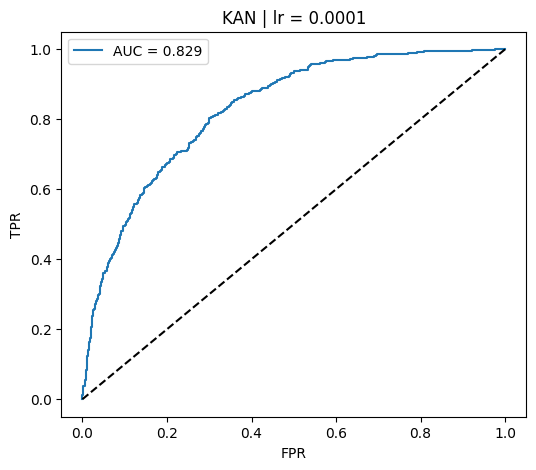

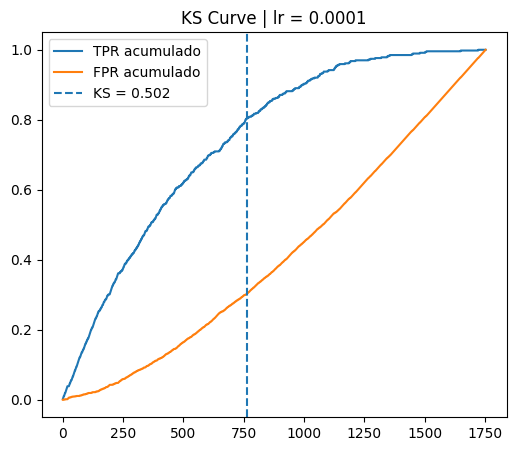

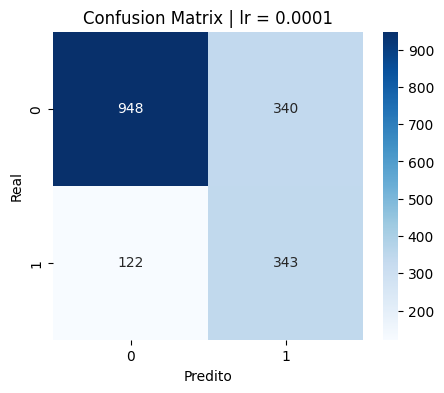

[I 2025-12-19 14:58:03,719] A new study created in memory with name: no-name-a26f3e08-ecd2-46f2-a1bf-f6dac691040f



===== Experimento KAN | lr = 0.0003 =====


[I 2025-12-19 14:58:08,772] Trial 0 finished with value: 0.07996894409937882 and parameters: {'n_layers': 3, 'hidden_size_0': 106, 'hidden_size_1': 73, 'hidden_size_2': 42, 'num_grids': 16, 'grid_min': -2.0580215656951877, 'grid_max': 0.6346542725472657, 'lr': 0.011803045814999408, 'weight_decay': 2.857289288853924e-05}. Best is trial 0 with value: 0.07996894409937882.
[I 2025-12-19 14:58:11,927] Trial 1 finished with value: 0.024844720496894457 and parameters: {'n_layers': 2, 'hidden_size_0': 62, 'hidden_size_1': 101, 'num_grids': 16, 'grid_min': -0.18207263001639484, 'grid_max': 1.5555398681470867, 'lr': 0.006229318959911775, 'weight_decay': 0.000292728382993182}. Best is trial 0 with value: 0.07996894409937882.
[I 2025-12-19 14:58:12,254] Trial 2 finished with value: 0.37655279503105593 and parameters: {'n_layers': 1, 'hidden_size_0': 46, 'num_grids': 8, 'grid_min': -0.6652430846385906, 'grid_max': 1.6078424626412957, 'lr': 0.001158609211684542, 'weight_decay': 2.8338518897771916e-0

Ep 001 | train_loss 0.5958 | val_loss 0.5157 | val_auc 0.8231 | val_ks 0.5124 | prec 0.731 | rec 0.802 | f1 0.765
Ep 002 | train_loss 0.5115 | val_loss 0.5024 | val_auc 0.8354 | val_ks 0.5272 | prec 0.753 | rec 0.780 | f1 0.766
Ep 003 | train_loss 0.4946 | val_loss 0.4956 | val_auc 0.8385 | val_ks 0.5388 | prec 0.739 | rec 0.806 | f1 0.771
Ep 004 | train_loss 0.4841 | val_loss 0.4925 | val_auc 0.8420 | val_ks 0.5520 | prec 0.755 | rec 0.774 | f1 0.764
Ep 005 | train_loss 0.4795 | val_loss 0.5009 | val_auc 0.8389 | val_ks 0.5512 | prec 0.762 | rec 0.764 | f1 0.763
Ep 006 | train_loss 0.4740 | val_loss 0.4920 | val_auc 0.8418 | val_ks 0.5637 | prec 0.750 | rec 0.811 | f1 0.780
Ep 007 | train_loss 0.4685 | val_loss 0.4980 | val_auc 0.8409 | val_ks 0.5512 | prec 0.764 | rec 0.759 | f1 0.762
Ep 008 | train_loss 0.4621 | val_loss 0.5000 | val_auc 0.8407 | val_ks 0.5489 | prec 0.767 | rec 0.751 | f1 0.759
Ep 009 | train_loss 0.4516 | val_loss 0.5037 | val_auc 0.8404 | val_ks 0.5411 | prec 0.7

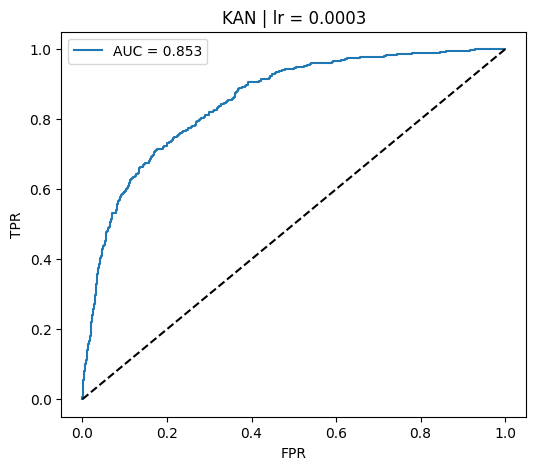

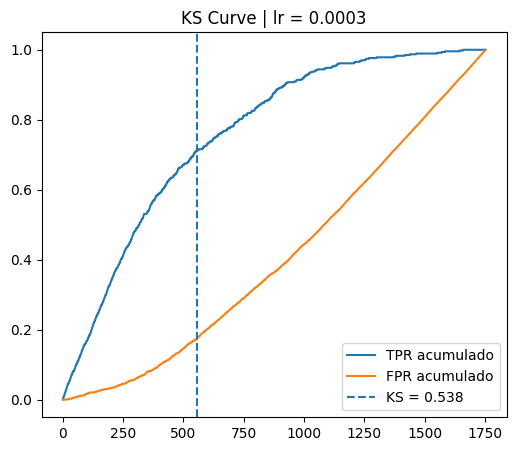

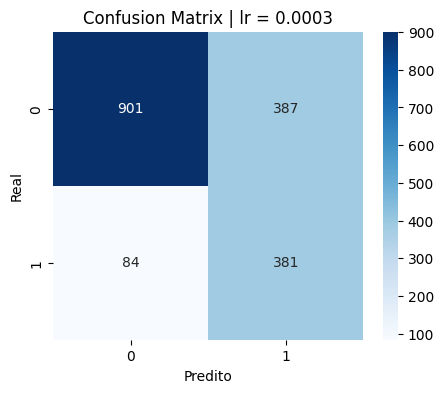

[I 2025-12-19 14:58:39,677] A new study created in memory with name: no-name-ffd4a7c2-8f20-4495-affa-0d3d183de757



===== Experimento KAN | lr = 0.001 =====


[I 2025-12-19 14:58:44,381] Trial 0 finished with value: 0.09083850931677018 and parameters: {'n_layers': 4, 'hidden_size_0': 112, 'hidden_size_1': 28, 'hidden_size_2': 123, 'hidden_size_3': 52, 'num_grids': 13, 'grid_min': -0.3192502291148607, 'grid_max': 0.4323373681675303, 'lr': 0.00276187354660172, 'weight_decay': 0.00011150497852948446}. Best is trial 0 with value: 0.09083850931677018.
[I 2025-12-19 14:58:50,218] Trial 1 finished with value: 0.4743788819875776 and parameters: {'n_layers': 3, 'hidden_size_0': 92, 'hidden_size_1': 226, 'hidden_size_2': 19, 'num_grids': 15, 'grid_min': -2.210103531544418, 'grid_max': 2.85372603523234, 'lr': 0.024454622899169418, 'weight_decay': 8.150163584294101e-07}. Best is trial 1 with value: 0.4743788819875776.
[I 2025-12-19 14:58:50,560] Trial 2 finished with value: 0.5357142857142858 and parameters: {'n_layers': 2, 'hidden_size_0': 38, 'hidden_size_1': 70, 'num_grids': 5, 'grid_min': -1.3808529326144443, 'grid_max': 1.1370094396601411, 'lr': 4.

Ep 001 | train_loss 0.6957 | val_loss 0.6552 | val_auc 0.6692 | val_ks 0.2795 | prec 0.608 | rec 0.758 | f1 0.675
Ep 002 | train_loss 0.6264 | val_loss 0.6101 | val_auc 0.7463 | val_ks 0.4130 | prec 0.685 | rec 0.756 | f1 0.719
Ep 003 | train_loss 0.5863 | val_loss 0.5820 | val_auc 0.7778 | val_ks 0.4519 | prec 0.709 | rec 0.737 | f1 0.723
Ep 004 | train_loss 0.5593 | val_loss 0.5621 | val_auc 0.7947 | val_ks 0.4705 | prec 0.721 | rec 0.758 | f1 0.739
Ep 005 | train_loss 0.5394 | val_loss 0.5498 | val_auc 0.8029 | val_ks 0.4752 | prec 0.734 | rec 0.741 | f1 0.738
Ep 006 | train_loss 0.5246 | val_loss 0.5417 | val_auc 0.8080 | val_ks 0.4868 | prec 0.737 | rec 0.739 | f1 0.738
Ep 007 | train_loss 0.5134 | val_loss 0.5344 | val_auc 0.8124 | val_ks 0.4992 | prec 0.738 | rec 0.752 | f1 0.745
Ep 008 | train_loss 0.5031 | val_loss 0.5304 | val_auc 0.8149 | val_ks 0.5016 | prec 0.746 | rec 0.751 | f1 0.748
Ep 009 | train_loss 0.4950 | val_loss 0.5262 | val_auc 0.8175 | val_ks 0.5062 | prec 0.7

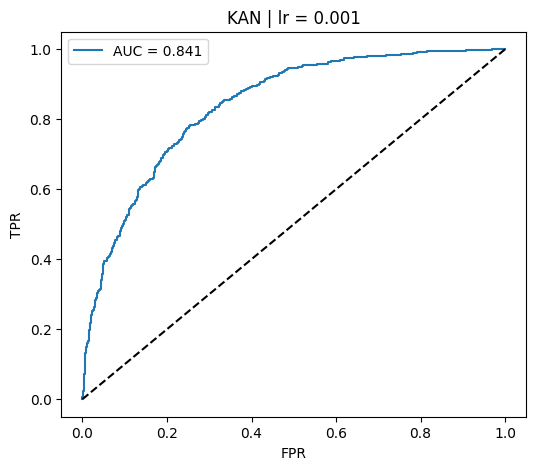

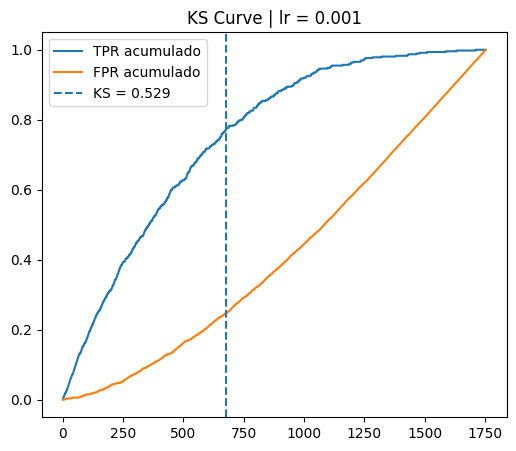

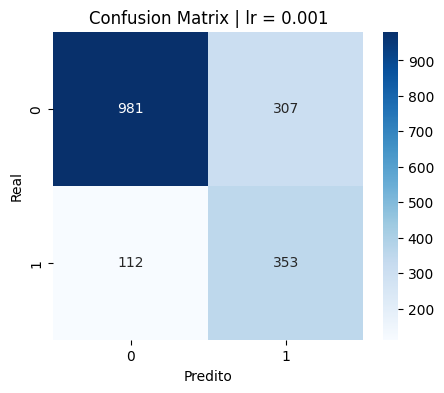

[I 2025-12-19 14:59:17,511] A new study created in memory with name: no-name-32388511-34b0-4850-96bd-07dc1cad34a5



===== Experimento KAN | lr = 0.003 =====


[I 2025-12-19 14:59:18,242] Trial 0 finished with value: 0.4875776397515529 and parameters: {'n_layers': 3, 'hidden_size_0': 143, 'hidden_size_1': 45, 'hidden_size_2': 43, 'num_grids': 6, 'grid_min': -0.11041607863697589, 'grid_max': 1.7357552470205713, 'lr': 3.793225224294839e-05, 'weight_decay': 0.00017596094623290636}. Best is trial 0 with value: 0.4875776397515529.
[I 2025-12-19 14:59:19,118] Trial 1 finished with value: 0.5131987577639752 and parameters: {'n_layers': 4, 'hidden_size_0': 73, 'hidden_size_1': 65, 'hidden_size_2': 43, 'hidden_size_3': 143, 'num_grids': 10, 'grid_min': -2.3150763264595207, 'grid_max': 2.5253547892834574, 'lr': 3.1597974471611066e-05, 'weight_decay': 0.0003374113781838594}. Best is trial 1 with value: 0.5131987577639752.
[I 2025-12-19 14:59:21,769] Trial 2 finished with value: 0.45031055900621114 and parameters: {'n_layers': 3, 'hidden_size_0': 206, 'hidden_size_1': 39, 'hidden_size_2': 234, 'num_grids': 9, 'grid_min': -1.4569849131543546, 'grid_max': 

Ep 001 | train_loss 0.5749 | val_loss 0.5122 | val_auc 0.8397 | val_ks 0.5326 | prec 0.694 | rec 0.891 | f1 0.780
Ep 002 | train_loss 0.5012 | val_loss 0.5049 | val_auc 0.8362 | val_ks 0.5311 | prec 0.772 | rec 0.717 | f1 0.743
Ep 003 | train_loss 0.4947 | val_loss 0.4977 | val_auc 0.8443 | val_ks 0.5404 | prec 0.724 | rec 0.864 | f1 0.788
Ep 004 | train_loss 0.4898 | val_loss 0.5045 | val_auc 0.8370 | val_ks 0.5474 | prec 0.774 | rec 0.731 | f1 0.752
Ep 005 | train_loss 0.4817 | val_loss 0.5085 | val_auc 0.8393 | val_ks 0.5171 | prec 0.702 | rec 0.872 | f1 0.778
Ep 006 | train_loss 0.4790 | val_loss 0.5056 | val_auc 0.8397 | val_ks 0.5280 | prec 0.788 | rec 0.696 | f1 0.739
Ep 007 | train_loss 0.4659 | val_loss 0.4972 | val_auc 0.8463 | val_ks 0.5543 | prec 0.698 | rec 0.891 | f1 0.783
Ep 008 | train_loss 0.4648 | val_loss 0.4998 | val_auc 0.8406 | val_ks 0.5342 | prec 0.739 | rec 0.805 | f1 0.771
Ep 009 | train_loss 0.4508 | val_loss 0.5261 | val_auc 0.8306 | val_ks 0.5085 | prec 0.7

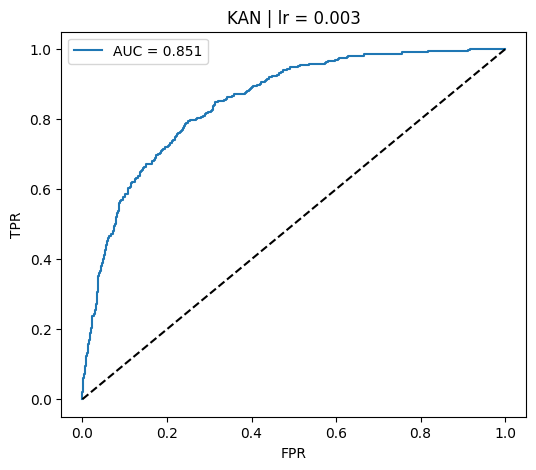

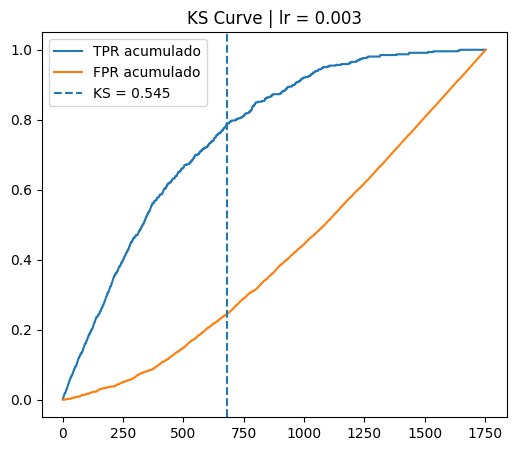

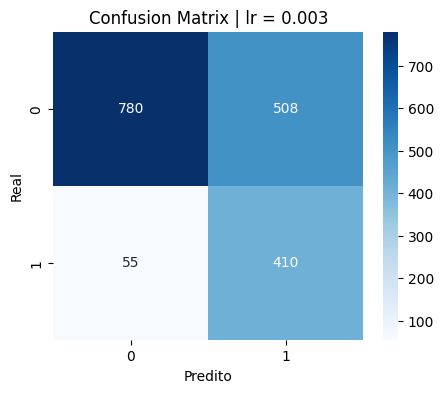

[I 2025-12-19 14:59:57,723] A new study created in memory with name: no-name-ccffde60-07b9-4cd7-aa00-da5d97cf8759



===== Experimento KAN | lr = 0.01 =====


[I 2025-12-19 14:59:59,510] Trial 0 finished with value: 0.22670807453416153 and parameters: {'n_layers': 3, 'hidden_size_0': 22, 'hidden_size_1': 87, 'hidden_size_2': 29, 'num_grids': 11, 'grid_min': -0.22647097424790807, 'grid_max': 0.9663825936790446, 'lr': 0.00031217845741421906, 'weight_decay': 4.088714158530217e-06}. Best is trial 0 with value: 0.22670807453416153.
[I 2025-12-19 15:00:01,371] Trial 1 finished with value: 0.5287267080745341 and parameters: {'n_layers': 3, 'hidden_size_0': 87, 'hidden_size_1': 22, 'hidden_size_2': 50, 'num_grids': 14, 'grid_min': -2.5578564596370175, 'grid_max': 0.9617249055902691, 'lr': 0.024870468888788407, 'weight_decay': 0.0002921881532589907}. Best is trial 1 with value: 0.5287267080745341.
[I 2025-12-19 15:00:03,793] Trial 2 finished with value: 0.5333850931677019 and parameters: {'n_layers': 4, 'hidden_size_0': 116, 'hidden_size_1': 19, 'hidden_size_2': 46, 'hidden_size_3': 98, 'num_grids': 10, 'grid_min': -0.30176252085020483, 'grid_max': 2

Ep 001 | train_loss 0.6605 | val_loss 0.5918 | val_auc 0.7540 | val_ks 0.3851 | prec 0.683 | rec 0.696 | f1 0.689
Ep 002 | train_loss 0.5285 | val_loss 0.5456 | val_auc 0.8005 | val_ks 0.4705 | prec 0.727 | rec 0.682 | f1 0.704
Ep 003 | train_loss 0.4715 | val_loss 0.5272 | val_auc 0.8147 | val_ks 0.4961 | prec 0.741 | rec 0.698 | f1 0.719
Ep 004 | train_loss 0.4361 | val_loss 0.5213 | val_auc 0.8184 | val_ks 0.5047 | prec 0.746 | rec 0.688 | f1 0.716
Ep 005 | train_loss 0.4102 | val_loss 0.5184 | val_auc 0.8214 | val_ks 0.5109 | prec 0.752 | rec 0.685 | f1 0.717
Ep 006 | train_loss 0.3886 | val_loss 0.5280 | val_auc 0.8209 | val_ks 0.5093 | prec 0.772 | rec 0.641 | f1 0.701
Ep 007 | train_loss 0.3703 | val_loss 0.5211 | val_auc 0.8206 | val_ks 0.5070 | prec 0.754 | rec 0.689 | f1 0.720
Ep 008 | train_loss 0.3529 | val_loss 0.5189 | val_auc 0.8235 | val_ks 0.5179 | prec 0.764 | rec 0.690 | f1 0.725
Ep 009 | train_loss 0.3384 | val_loss 0.5238 | val_auc 0.8228 | val_ks 0.5202 | prec 0.7

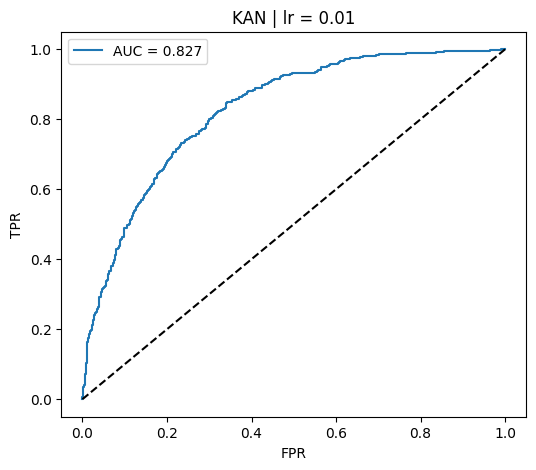

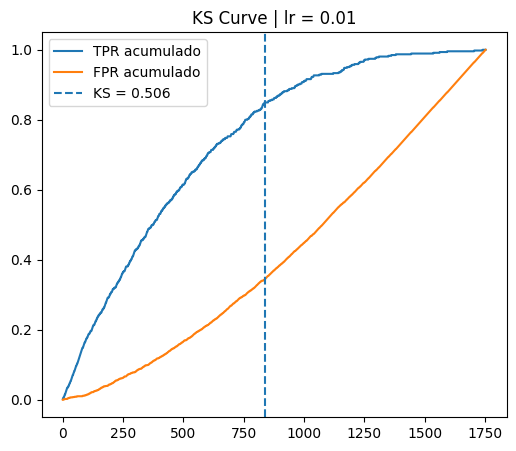

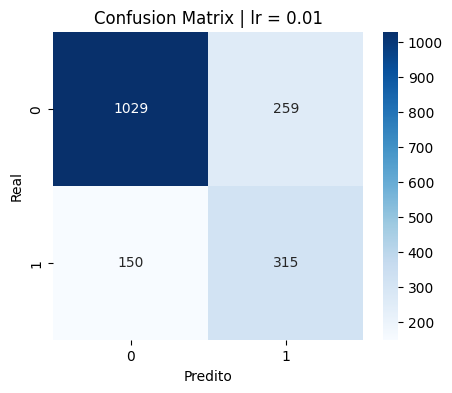

In [ ]:
LRS = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
summary = []

for lr_fixed in LRS:

    print(f"\n===== Experimento KAN | lr = {lr_fixed} =====")

    # ─── 1. FIXA PARÂMETRO ─────────────────────────────
    fixed_params = {
        "lr": lr_fixed
    }

    # ─── 2. OPTUNA ─────────────────────────────────────
    study = optuna.create_study(direction="maximize")
    study.optimize(
        objective_factory(
            experiment_name=f"KAN_lr_{lr_fixed}",
            fixed_params=fixed_params
        ),
        n_trials=15
    )

    best_params = {**fixed_params, **study.best_params}

    # ─── 3. RECONSTRÓI MODELO FINAL ────────────────────
    input_dim = X_train_over.shape[1]

    layers = [input_dim]
    for i in range(best_params["n_layers"]):
        layers.append(best_params[f"hidden_size_{i}"])
    layers.append(1)

    model = FastKAN(
        layers_hidden=layers,
        num_grids=best_params["num_grids"],
        grid_min=best_params["grid_min"],
        grid_max=best_params["grid_max"]
    )

    # ─── 4. TREINO FINAL COMPLETO ──────────────────────
    model, history, test_metrics = train_fastkan(
        model,
        train_dl,
        val_dl,
        test_dl,
        device="cuda",
        epochs=40,
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"],
        patience=8
    )

    y_true = test_metrics["y_true"]
    y_score = test_metrics["y_score"]

    # ─── 5. GRÁFICOS ───────────────────────────────────
    auc_score = plot_roc_curve(
        y_true,
        y_score,
        title=f"KAN | lr = {lr_fixed}"
    )

    ks_score = ks_curve(
        y_true,
        y_score,
        title=f"KS Curve | lr = {lr_fixed}"
    )

    plot_confusion(
        y_true,
        y_score,
        title=f"Confusion Matrix | lr = {lr_fixed}"
    )

    # ─── 6. SUMMARY ────────────────────────────────────
    summary.append({
        "lr": lr_fixed,
        "ks": ks_score,
        "auc": auc_score
    })


In [ ]:
summary_df = pd.DataFrame(summary)
summary_df

,lr,ks,auc
0,0.0001,0.502282,0.829069
1,0.0003,0.537915,0.852655
2,0.0010,0.529450,0.840506
3,0.0030,0.544682,0.850611
4,0.0100,0.506295,0.826852


[I 2025-12-19 15:03:57,558] A new study created in memory with name: no-name-f20de050-9409-42aa-9098-cf70a7dbfc00



===== Experimento KAN | grid_range = [-1.0, 1.0] =====


[I 2025-12-19 15:03:59,878] Trial 0 finished with value: 0.05512422360248448 and parameters: {'n_layers': 4, 'hidden_size_0': 23, 'hidden_size_1': 75, 'hidden_size_2': 19, 'hidden_size_3': 30, 'num_grids': 16, 'grid_min': -1.0942794886527603, 'grid_max': 2.8369070076168468, 'lr': 0.0001728052103443191, 'weight_decay': 1.05959896129895e-05}. Best is trial 0 with value: 0.05512422360248448.
[I 2025-12-19 15:04:04,678] Trial 1 finished with value: 0.0908385093167702 and parameters: {'n_layers': 3, 'hidden_size_0': 246, 'hidden_size_1': 16, 'hidden_size_2': 98, 'num_grids': 14, 'grid_min': -1.1844538648293286, 'grid_max': 0.8268257838478906, 'lr': 0.00022837161933029056, 'weight_decay': 9.182844926322238e-07}. Best is trial 1 with value: 0.0908385093167702.
[I 2025-12-19 15:04:05,189] Trial 2 finished with value: 0.4992236024844721 and parameters: {'n_layers': 2, 'hidden_size_0': 64, 'hidden_size_1': 62, 'num_grids': 7, 'grid_min': -2.1575006688470233, 'grid_max': 1.1455964502774298, 'lr':

Ep 001 | train_loss 0.5201 | val_loss 0.4988 | val_auc 0.8425 | val_ks 0.5365 | prec 0.728 | rec 0.848 | f1 0.783
Ep 002 | train_loss 0.4779 | val_loss 0.5179 | val_auc 0.8469 | val_ks 0.5419 | prec 0.804 | rec 0.682 | f1 0.738
Ep 003 | train_loss 0.4676 | val_loss 0.5058 | val_auc 0.8420 | val_ks 0.5287 | prec 0.776 | rec 0.723 | f1 0.749
Ep 004 | train_loss 0.4599 | val_loss 0.5059 | val_auc 0.8403 | val_ks 0.5388 | prec 0.711 | rec 0.855 | f1 0.776
Ep 005 | train_loss 0.4360 | val_loss 0.5007 | val_auc 0.8402 | val_ks 0.5435 | prec 0.752 | rec 0.774 | f1 0.763
Ep 006 | train_loss 0.4229 | val_loss 0.5387 | val_auc 0.8358 | val_ks 0.5450 | prec 0.788 | rec 0.684 | f1 0.732
Ep 007 | train_loss 0.4133 | val_loss 0.5549 | val_auc 0.8312 | val_ks 0.5241 | prec 0.788 | rec 0.668 | f1 0.723
Ep 008 | train_loss 0.4041 | val_loss 0.5278 | val_auc 0.8321 | val_ks 0.5404 | prec 0.771 | rec 0.719 | f1 0.744
Ep 009 | train_loss 0.3870 | val_loss 0.5825 | val_auc 0.8198 | val_ks 0.5008 | prec 0.7

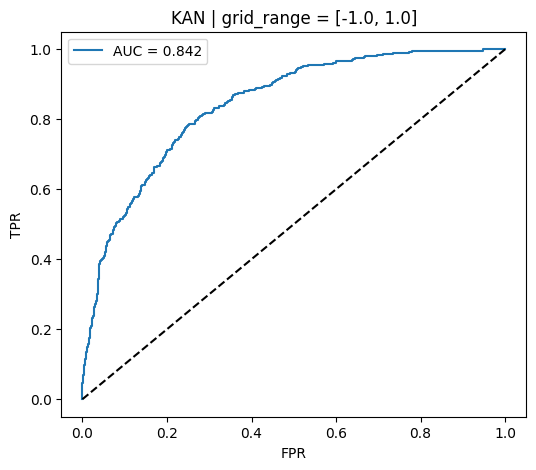

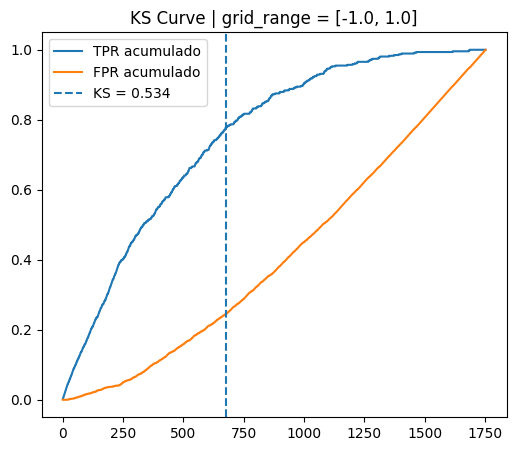

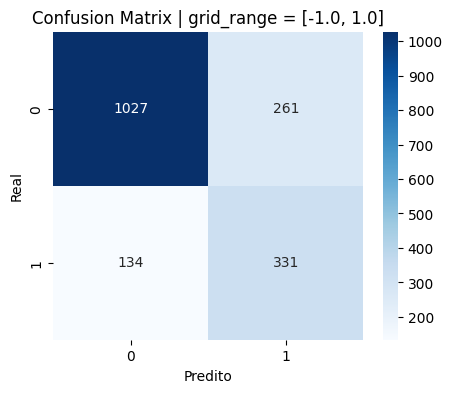

[I 2025-12-19 15:04:30,209] A new study created in memory with name: no-name-d547d558-1360-4d7b-ae1e-817a3bcfecce



===== Experimento KAN | grid_range = [-2.0, 2.0] =====


[I 2025-12-19 15:04:31,521] Trial 0 finished with value: 0.06832298136645962 and parameters: {'n_layers': 2, 'hidden_size_0': 52, 'hidden_size_1': 20, 'num_grids': 15, 'grid_min': -1.5504875584376157, 'grid_max': 0.9322461159465983, 'lr': 1.596549443963923e-05, 'weight_decay': 0.00014487741774447583}. Best is trial 0 with value: 0.06832298136645962.
[I 2025-12-19 15:04:39,230] Trial 1 finished with value: 0.4945652173913043 and parameters: {'n_layers': 4, 'hidden_size_0': 200, 'hidden_size_1': 230, 'hidden_size_2': 128, 'hidden_size_3': 85, 'num_grids': 12, 'grid_min': -0.2128019174841147, 'grid_max': 1.9726204972104782, 'lr': 0.002124537399832377, 'weight_decay': 5.895954078722338e-06}. Best is trial 1 with value: 0.4945652173913043.
[I 2025-12-19 15:04:39,972] Trial 2 finished with value: 0.5349378881987579 and parameters: {'n_layers': 4, 'hidden_size_0': 232, 'hidden_size_1': 35, 'hidden_size_2': 77, 'hidden_size_3': 40, 'num_grids': 7, 'grid_min': -2.6990675526440295, 'grid_max': 0

Ep 001 | train_loss 0.5149 | val_loss 0.4838 | val_auc 0.8460 | val_ks 0.5536 | prec 0.745 | rec 0.802 | f1 0.773
Ep 002 | train_loss 0.4792 | val_loss 0.5067 | val_auc 0.8458 | val_ks 0.5512 | prec 0.705 | rec 0.903 | f1 0.792
Ep 003 | train_loss 0.4655 | val_loss 0.4913 | val_auc 0.8418 | val_ks 0.5380 | prec 0.750 | rec 0.785 | f1 0.767
Ep 004 | train_loss 0.4444 | val_loss 0.5065 | val_auc 0.8368 | val_ks 0.5427 | prec 0.730 | rec 0.843 | f1 0.782
Ep 005 | train_loss 0.4225 | val_loss 0.5622 | val_auc 0.8148 | val_ks 0.5031 | prec 0.776 | rec 0.608 | f1 0.682
Ep 006 | train_loss 0.4016 | val_loss 0.5259 | val_auc 0.8287 | val_ks 0.5427 | prec 0.756 | rec 0.719 | f1 0.737
Ep 007 | train_loss 0.3763 | val_loss 0.5486 | val_auc 0.8315 | val_ks 0.5458 | prec 0.754 | rec 0.789 | f1 0.771
Ep 008 | train_loss 0.3635 | val_loss 0.6315 | val_auc 0.8177 | val_ks 0.5023 | prec 0.777 | rec 0.597 | f1 0.675
Ep 009 | train_loss 0.3365 | val_loss 0.5658 | val_auc 0.8191 | val_ks 0.5303 | prec 0.7

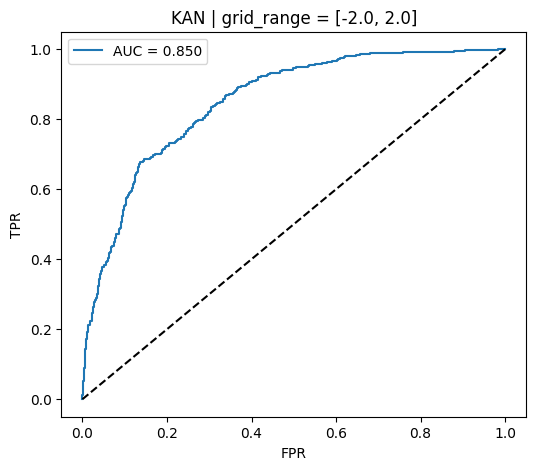

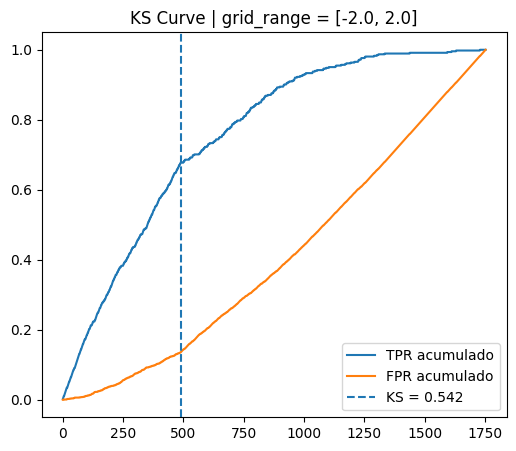

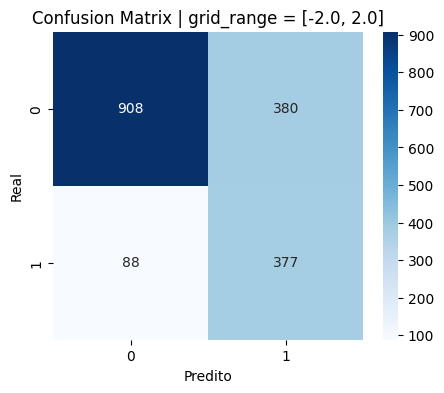

[I 2025-12-19 15:04:53,609] A new study created in memory with name: no-name-d9e4b7cb-fade-41ea-9e5e-71c9281b0384



===== Experimento KAN | grid_range = [-3.0, 3.0] =====


[I 2025-12-19 15:04:54,101] Trial 0 finished with value: 0.4953416149068323 and parameters: {'n_layers': 1, 'hidden_size_0': 175, 'num_grids': 11, 'grid_min': -2.5799313676099827, 'grid_max': 2.8114928107475654, 'lr': 0.0003162243235884457, 'weight_decay': 7.132321981794094e-08}. Best is trial 0 with value: 0.4953416149068323.
[I 2025-12-19 15:04:54,726] Trial 1 finished with value: 0.5287267080745341 and parameters: {'n_layers': 3, 'hidden_size_0': 25, 'hidden_size_1': 249, 'hidden_size_2': 18, 'num_grids': 6, 'grid_min': -1.4996134201455562, 'grid_max': 2.9760966636256003, 'lr': 0.000665268679561292, 'weight_decay': 5.722899533599027e-08}. Best is trial 1 with value: 0.5287267080745341.
[I 2025-12-19 15:04:55,209] Trial 2 finished with value: 0.48059006211180116 and parameters: {'n_layers': 1, 'hidden_size_0': 76, 'num_grids': 12, 'grid_min': -1.955393421144739, 'grid_max': 1.4403426042813368, 'lr': 0.00023456974889456573, 'weight_decay': 1.5178791356706874e-06}. Best is trial 1 with

Ep 001 | train_loss 0.5665 | val_loss 0.5014 | val_auc 0.8375 | val_ks 0.5233 | prec 0.759 | rec 0.732 | f1 0.745
Ep 002 | train_loss 0.4870 | val_loss 0.4949 | val_auc 0.8452 | val_ks 0.5536 | prec 0.786 | rec 0.723 | f1 0.753
Ep 003 | train_loss 0.4672 | val_loss 0.4880 | val_auc 0.8464 | val_ks 0.5536 | prec 0.775 | rec 0.758 | f1 0.766
Ep 004 | train_loss 0.4524 | val_loss 0.4847 | val_auc 0.8482 | val_ks 0.5474 | prec 0.775 | rec 0.763 | f1 0.769
Ep 005 | train_loss 0.4371 | val_loss 0.4906 | val_auc 0.8444 | val_ks 0.5450 | prec 0.763 | rec 0.783 | f1 0.773
Ep 006 | train_loss 0.4249 | val_loss 0.4909 | val_auc 0.8453 | val_ks 0.5528 | prec 0.773 | rec 0.773 | f1 0.773
Ep 007 | train_loss 0.4127 | val_loss 0.4972 | val_auc 0.8426 | val_ks 0.5411 | prec 0.771 | rec 0.765 | f1 0.768
Ep 008 | train_loss 0.3944 | val_loss 0.5098 | val_auc 0.8384 | val_ks 0.5404 | prec 0.770 | rec 0.721 | f1 0.745
Ep 009 | train_loss 0.3824 | val_loss 0.5110 | val_auc 0.8352 | val_ks 0.5295 | prec 0.7

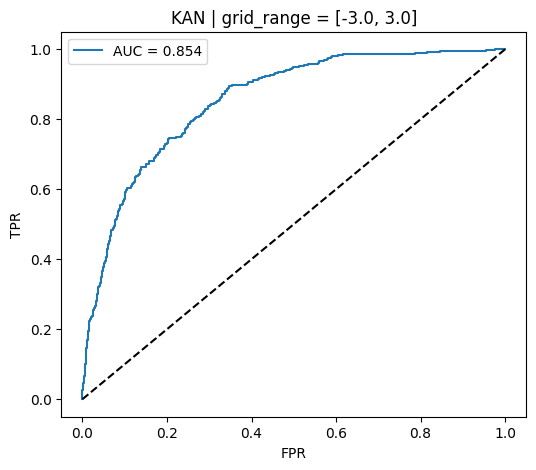

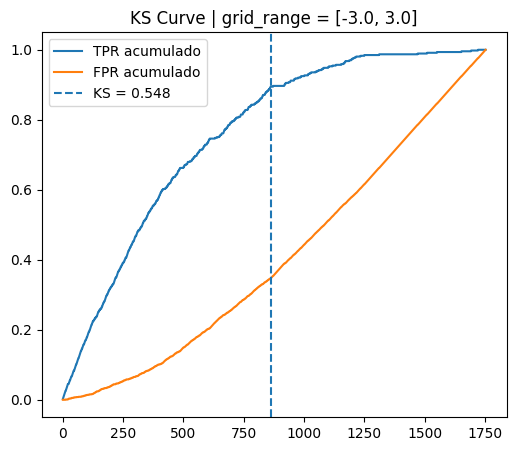

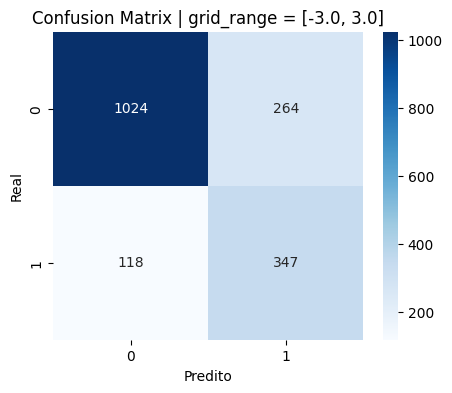

[I 2025-12-19 15:05:19,672] A new study created in memory with name: no-name-1ec98099-f9c6-47a5-b543-02353311c212



===== Experimento KAN | grid_range = [-4.0, 4.0] =====


[I 2025-12-19 15:05:20,259] Trial 0 finished with value: 0.28726708074534163 and parameters: {'n_layers': 3, 'hidden_size_0': 220, 'hidden_size_1': 18, 'hidden_size_2': 29, 'num_grids': 6, 'grid_min': -2.1051093940635566, 'grid_max': 2.0877975977554755, 'lr': 1.0230998824545016e-05, 'weight_decay': 5.598467980103621e-08}. Best is trial 0 with value: 0.28726708074534163.
[I 2025-12-19 15:05:20,621] Trial 1 finished with value: 0.5543478260869565 and parameters: {'n_layers': 2, 'hidden_size_0': 24, 'hidden_size_1': 31, 'num_grids': 10, 'grid_min': -1.041573309602875, 'grid_max': 0.3110987134174016, 'lr': 0.009006797754785913, 'weight_decay': 1.198248442547587e-08}. Best is trial 1 with value: 0.5543478260869565.
[I 2025-12-19 15:05:20,937] Trial 2 finished with value: 0.10636645962732927 and parameters: {'n_layers': 1, 'hidden_size_0': 57, 'num_grids': 11, 'grid_min': -2.16617073435943, 'grid_max': 0.23404028324596082, 'lr': 2.391018402267717e-05, 'weight_decay': 3.764366980049466e-08}. 

Ep 001 | train_loss 0.5465 | val_loss 0.5525 | val_auc 0.8426 | val_ks 0.5342 | prec 0.815 | rec 0.610 | f1 0.698
Ep 002 | train_loss 0.4900 | val_loss 0.4832 | val_auc 0.8524 | val_ks 0.5590 | prec 0.743 | rec 0.840 | f1 0.788
Ep 003 | train_loss 0.4895 | val_loss 0.5076 | val_auc 0.8445 | val_ks 0.5606 | prec 0.707 | rec 0.870 | f1 0.780
Ep 004 | train_loss 0.4811 | val_loss 0.4992 | val_auc 0.8381 | val_ks 0.5481 | prec 0.739 | rec 0.813 | f1 0.774
Ep 005 | train_loss 0.4792 | val_loss 0.4967 | val_auc 0.8444 | val_ks 0.5590 | prec 0.750 | rec 0.816 | f1 0.781
Ep 006 | train_loss 0.4697 | val_loss 0.5654 | val_auc 0.8275 | val_ks 0.5202 | prec 0.817 | rec 0.530 | f1 0.642
Ep 007 | train_loss 0.4624 | val_loss 0.5075 | val_auc 0.8425 | val_ks 0.5435 | prec 0.751 | rec 0.762 | f1 0.756
Ep 008 | train_loss 0.4598 | val_loss 0.5293 | val_auc 0.8190 | val_ks 0.5148 | prec 0.731 | rec 0.786 | f1 0.757
Ep 009 | train_loss 0.4536 | val_loss 0.5342 | val_auc 0.8286 | val_ks 0.5264 | prec 0.7

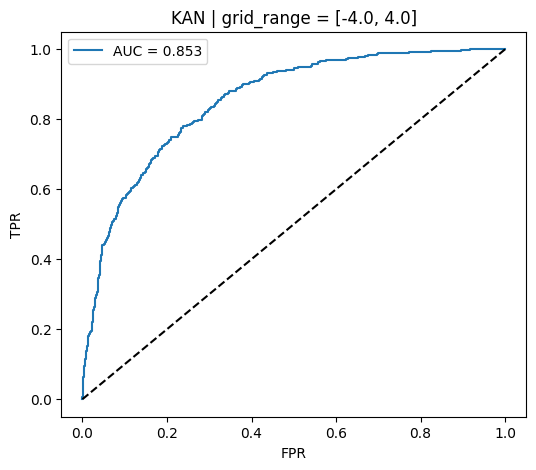

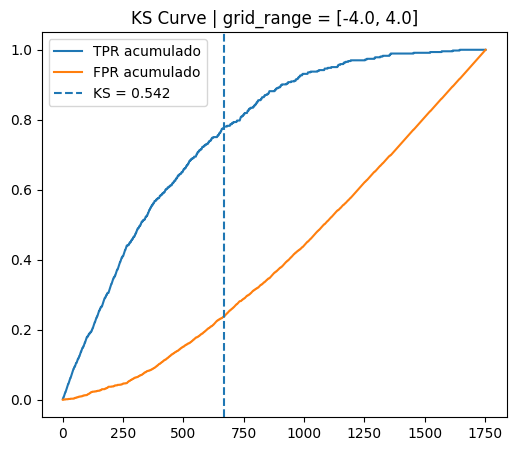

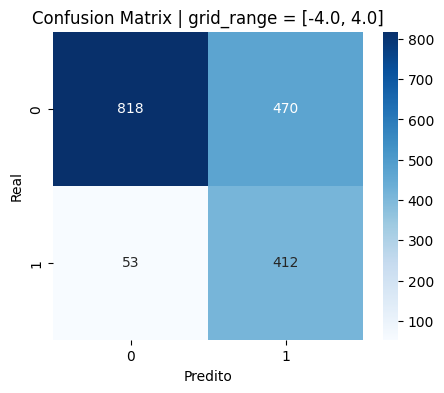

In [ ]:
GRID_RANGES = [
    (-1.0, 1.0),
    (-2.0, 2.0),
    (-3.0, 3.0),
    (-4.0, 4.0),
]

summary = []

for grid_min, grid_max in GRID_RANGES:

    print(f"\n===== Experimento KAN | grid_range = [{grid_min}, {grid_max}] =====")

    # ─── 1. FIXA PARÂMETRO ─────────────────────────────
    fixed_params = {
        "grid_min": grid_min,
        "grid_max": grid_max
    }

    # ─── 2. OPTUNA ─────────────────────────────────────
    study = optuna.create_study(direction="maximize")
    study.optimize(
        objective_factory(
            experiment_name=f"KAN_grid_{grid_min}_{grid_max}",
            fixed_params=fixed_params
        ),
        n_trials=15
    )

    best_params = {**fixed_params, **study.best_params}

    # ─── 3. RECONSTRÓI MODELO FINAL ────────────────────
    input_dim = X_train_over.shape[1]

    layers = [input_dim]
    for i in range(best_params["n_layers"]):
        layers.append(best_params[f"hidden_size_{i}"])
    layers.append(1)

    model = FastKAN(
        layers_hidden=layers,
        num_grids=best_params["num_grids"],
        grid_min=grid_min,   # fixado
        grid_max=grid_max    # fixado
    )

    # ─── 4. TREINO FINAL COMPLETO ──────────────────────
    model, history, test_metrics = train_fastkan(
        model,
        train_dl,
        val_dl,
        test_dl,
        device="cuda",
        epochs=40,
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"],
        patience=8
    )

    y_true = test_metrics["y_true"]
    y_score = test_metrics["y_score"]

    # ─── 5. GRÁFICOS ───────────────────────────────────
    auc_score = plot_roc_curve(
        y_true,
        y_score,
        title=f"KAN | grid_range = [{grid_min}, {grid_max}]"
    )

    ks_score = ks_curve(
        y_true,
        y_score,
        title=f"KS Curve | grid_range = [{grid_min}, {grid_max}]"
    )

    plot_confusion(
        y_true,
        y_score,
        title=f"Confusion Matrix | grid_range = [{grid_min}, {grid_max}]"
    )

    # ─── 6. SUMMARY ────────────────────────────────────
    summary.append({
        "grid_min": grid_min,
        "grid_max": grid_max,
        "ks": ks_score,
        "auc": auc_score
    })


In [ ]:
summary_df = pd.DataFrame(summary)
summary_df

,grid_min,grid_max,ks,auc
0,-1.0,1.0,0.533929,0.841737
1,-2.0,2.0,0.542326,0.849983
2,-3.0,3.0,0.548350,0.853822
3,-4.0,4.0,0.542291,0.853268


[I 2025-12-19 15:07:26,393] A new study created in memory with name: no-name-c70547f0-9440-469b-8032-a30c4b8da7d3



===== Experimento KAN | hidden_size = 16 =====


[I 2025-12-19 15:07:26,755] Trial 0 finished with value: 0.5209627329192548 and parameters: {'num_grids': 10, 'grid_min': -0.24496578301457905, 'grid_max': 2.283686510368768, 'lr': 0.0029637692813826305, 'weight_decay': 3.2764487465160095e-08}. Best is trial 0 with value: 0.5209627329192548.
[I 2025-12-19 15:07:27,062] Trial 1 finished with value: 0.5481366459627329 and parameters: {'num_grids': 9, 'grid_min': -2.877761301813742, 'grid_max': 0.37478596223309013, 'lr': 0.037857809514226945, 'weight_decay': 1.224657337912194e-06}. Best is trial 1 with value: 0.5481366459627329.
[I 2025-12-19 15:07:27,431] Trial 2 finished with value: 0.028726708074534202 and parameters: {'num_grids': 13, 'grid_min': -2.8298707696891676, 'grid_max': 1.1568578090240422, 'lr': 2.9314075661460252e-05, 'weight_decay': 3.129324207519133e-05}. Best is trial 1 with value: 0.5481366459627329.
[I 2025-12-19 15:07:27,677] Trial 3 finished with value: 0.5163043478260869 and parameters: {'num_grids': 7, 'grid_min': -

Ep 001 | train_loss 0.5272 | val_loss 0.4881 | val_auc 0.8458 | val_ks 0.5543 | prec 0.766 | rec 0.776 | f1 0.771
Ep 002 | train_loss 0.4860 | val_loss 0.4881 | val_auc 0.8506 | val_ks 0.5551 | prec 0.736 | rec 0.859 | f1 0.793
Ep 003 | train_loss 0.4790 | val_loss 0.4886 | val_auc 0.8460 | val_ks 0.5567 | prec 0.765 | rec 0.778 | f1 0.771
Ep 004 | train_loss 0.4844 | val_loss 0.4957 | val_auc 0.8398 | val_ks 0.5311 | prec 0.748 | rec 0.769 | f1 0.758
Ep 005 | train_loss 0.4655 | val_loss 0.5459 | val_auc 0.8361 | val_ks 0.5481 | prec 0.817 | rec 0.570 | f1 0.672
Ep 006 | train_loss 0.4625 | val_loss 0.5235 | val_auc 0.8412 | val_ks 0.5435 | prec 0.721 | rec 0.859 | f1 0.784
Ep 007 | train_loss 0.4523 | val_loss 0.5012 | val_auc 0.8365 | val_ks 0.5380 | prec 0.745 | rec 0.795 | f1 0.769
Ep 008 | train_loss 0.4401 | val_loss 0.5190 | val_auc 0.8346 | val_ks 0.5365 | prec 0.759 | rec 0.773 | f1 0.766
Ep 009 | train_loss 0.4412 | val_loss 0.5262 | val_auc 0.8221 | val_ks 0.5109 | prec 0.7

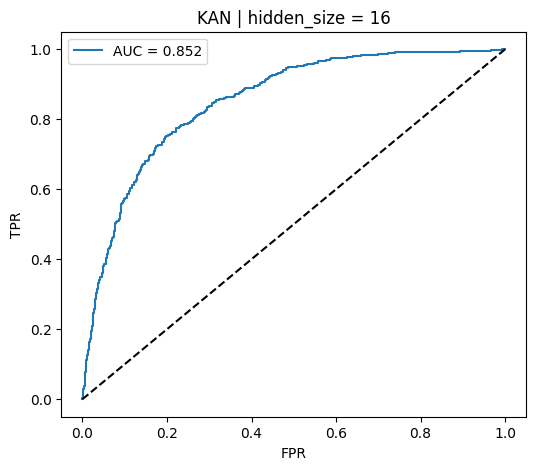

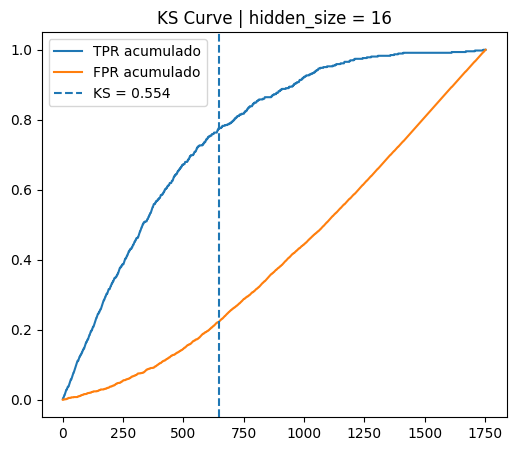

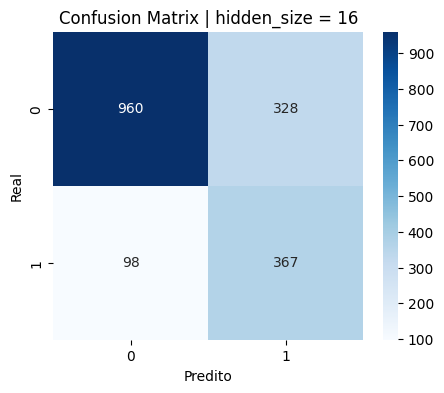

[I 2025-12-19 15:07:36,203] A new study created in memory with name: no-name-b091eb37-06d1-44ce-b427-bd761113ddc3



===== Experimento KAN | hidden_size = 32 =====


[I 2025-12-19 15:07:36,481] Trial 0 finished with value: 0.4767080745341615 and parameters: {'num_grids': 7, 'grid_min': -0.37876823547699745, 'grid_max': 2.8253577584876814, 'lr': 0.0007130222500738009, 'weight_decay': 3.4234797548708206e-05}. Best is trial 0 with value: 0.4767080745341615.
[I 2025-12-19 15:07:36,735] Trial 1 finished with value: 0.5388198757763976 and parameters: {'num_grids': 6, 'grid_min': -2.4867567665497505, 'grid_max': 0.35831656702586967, 'lr': 0.030790098649863276, 'weight_decay': 1.1460316106421529e-07}. Best is trial 1 with value: 0.5388198757763976.
[I 2025-12-19 15:07:37,299] Trial 2 finished with value: 0.4681677018633541 and parameters: {'num_grids': 13, 'grid_min': -0.8256562456142156, 'grid_max': 2.072371028949573, 'lr': 0.0011997247396734858, 'weight_decay': 6.150874219968904e-07}. Best is trial 1 with value: 0.5388198757763976.
[I 2025-12-19 15:07:37,705] Trial 3 finished with value: 0.06211180124223603 and parameters: {'num_grids': 13, 'grid_min': -

Ep 001 | train_loss 0.5212 | val_loss 0.4853 | val_auc 0.8474 | val_ks 0.5357 | prec 0.748 | rec 0.787 | f1 0.767
Ep 002 | train_loss 0.4811 | val_loss 0.5175 | val_auc 0.8426 | val_ks 0.5287 | prec 0.701 | rec 0.884 | f1 0.782
Ep 003 | train_loss 0.4674 | val_loss 0.4865 | val_auc 0.8490 | val_ks 0.5520 | prec 0.765 | rec 0.786 | f1 0.775
Ep 004 | train_loss 0.4461 | val_loss 0.5327 | val_auc 0.8398 | val_ks 0.5241 | prec 0.799 | rec 0.668 | f1 0.727
Ep 005 | train_loss 0.4358 | val_loss 0.5323 | val_auc 0.8374 | val_ks 0.5272 | prec 0.801 | rec 0.628 | f1 0.704
Ep 006 | train_loss 0.4215 | val_loss 0.5182 | val_auc 0.8344 | val_ks 0.5233 | prec 0.771 | rec 0.696 | f1 0.731
Ep 007 | train_loss 0.3991 | val_loss 0.5338 | val_auc 0.8322 | val_ks 0.5171 | prec 0.766 | rec 0.717 | f1 0.740
Ep 008 | train_loss 0.3798 | val_loss 0.5791 | val_auc 0.8143 | val_ks 0.4938 | prec 0.773 | rec 0.655 | f1 0.709
Ep 009 | train_loss 0.3676 | val_loss 0.5635 | val_auc 0.8171 | val_ks 0.5000 | prec 0.7

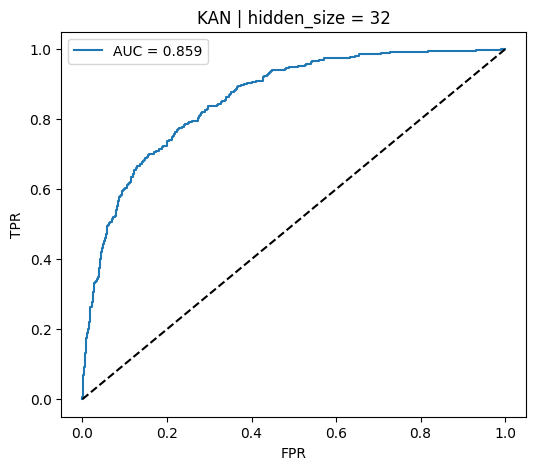

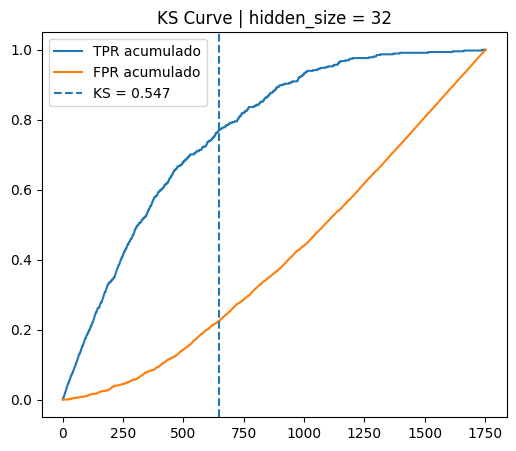

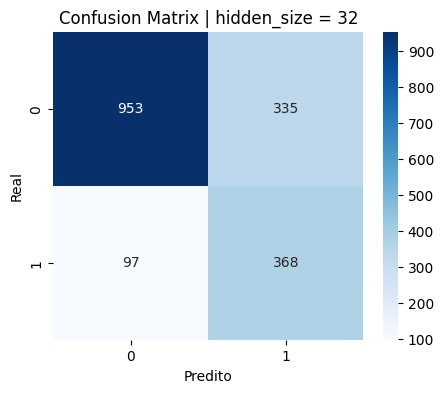

[I 2025-12-19 15:07:45,628] A new study created in memory with name: no-name-614f7ede-1dd1-4a4a-954b-aea3e31b4ed6



===== Experimento KAN | hidden_size = 64 =====


[I 2025-12-19 15:07:46,038] Trial 0 finished with value: 0.4751552795031056 and parameters: {'num_grids': 5, 'grid_min': -1.8259739510687514, 'grid_max': 0.2706265272262588, 'lr': 0.0002335217457245516, 'weight_decay': 1.016082216518746e-07}. Best is trial 0 with value: 0.4751552795031056.
[I 2025-12-19 15:07:46,608] Trial 1 finished with value: 0.5178571428571428 and parameters: {'num_grids': 12, 'grid_min': -2.027120534205288, 'grid_max': 2.7322467175127176, 'lr': 0.000911916812454163, 'weight_decay': 4.3913968969315786e-07}. Best is trial 1 with value: 0.5178571428571428.
[I 2025-12-19 15:07:47,171] Trial 2 finished with value: 0.32220496894409933 and parameters: {'num_grids': 10, 'grid_min': -2.408028506762471, 'grid_max': 1.1858836236854864, 'lr': 0.00015204202080984136, 'weight_decay': 1.7154320306393702e-05}. Best is trial 1 with value: 0.5178571428571428.
[I 2025-12-19 15:07:47,570] Trial 3 finished with value: 0.5326086956521738 and parameters: {'num_grids': 4, 'grid_min': -0.

Ep 001 | train_loss 0.6651 | val_loss 0.5314 | val_auc 0.8445 | val_ks 0.5435 | prec 0.811 | rec 0.644 | f1 0.718
Ep 002 | train_loss 0.5195 | val_loss 0.5597 | val_auc 0.8435 | val_ks 0.5396 | prec 0.824 | rec 0.564 | f1 0.670
Ep 003 | train_loss 0.5021 | val_loss 0.4945 | val_auc 0.8499 | val_ks 0.5505 | prec 0.805 | rec 0.703 | f1 0.750
Ep 004 | train_loss 0.4951 | val_loss 0.5158 | val_auc 0.8461 | val_ks 0.5536 | prec 0.801 | rec 0.686 | f1 0.739
Ep 005 | train_loss 0.4723 | val_loss 0.4938 | val_auc 0.8478 | val_ks 0.5652 | prec 0.777 | rec 0.739 | f1 0.757
Ep 006 | train_loss 0.4723 | val_loss 0.5466 | val_auc 0.8454 | val_ks 0.5427 | prec 0.814 | rec 0.668 | f1 0.733
Ep 007 | train_loss 0.4829 | val_loss 0.5159 | val_auc 0.8445 | val_ks 0.5443 | prec 0.701 | rec 0.892 | f1 0.785
Ep 008 | train_loss 0.4604 | val_loss 0.5256 | val_auc 0.8392 | val_ks 0.5365 | prec 0.777 | rec 0.740 | f1 0.758
Ep 009 | train_loss 0.4655 | val_loss 0.5923 | val_auc 0.8190 | val_ks 0.5093 | prec 0.7

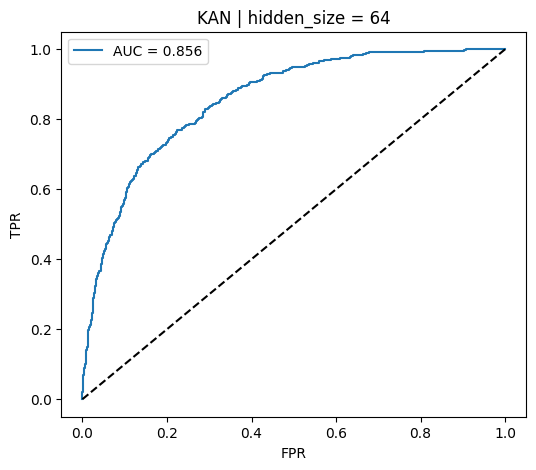

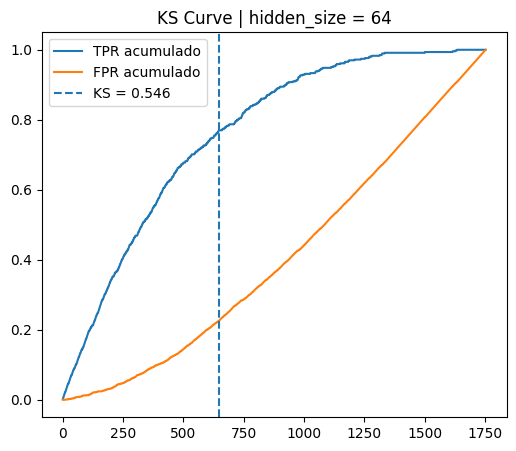

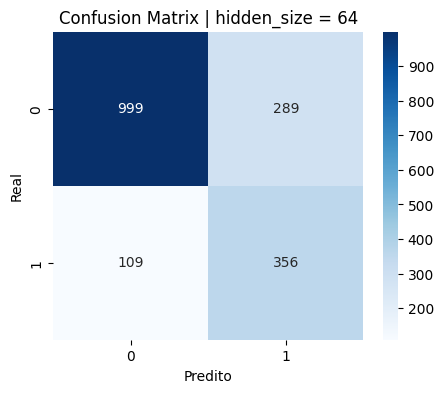

[I 2025-12-19 15:07:57,856] A new study created in memory with name: no-name-0b53e110-a17d-4b8f-88e2-3749409b2927



===== Experimento KAN | hidden_size = 128 =====


[I 2025-12-19 15:07:58,766] Trial 0 finished with value: 0.09860248447204972 and parameters: {'num_grids': 10, 'grid_min': -2.623700162570365, 'grid_max': 0.33466864152870845, 'lr': 1.0309635102177016e-05, 'weight_decay': 1.5090512099191277e-05}. Best is trial 0 with value: 0.09860248447204972.
[I 2025-12-19 15:07:59,147] Trial 1 finished with value: 0.515527950310559 and parameters: {'num_grids': 7, 'grid_min': -1.0909781722203102, 'grid_max': 1.518687562067086, 'lr': 0.0028046202222379055, 'weight_decay': 2.610423978547709e-05}. Best is trial 1 with value: 0.515527950310559.
[I 2025-12-19 15:08:00,741] Trial 2 finished with value: 0.5069875776397514 and parameters: {'num_grids': 13, 'grid_min': -2.141631250655819, 'grid_max': 0.27397816738348546, 'lr': 0.006912038547871303, 'weight_decay': 1.1199588434292695e-06}. Best is trial 1 with value: 0.515527950310559.
[I 2025-12-19 15:08:01,921] Trial 3 finished with value: 0.4720496894409938 and parameters: {'num_grids': 9, 'grid_min': -0.7

Ep 001 | train_loss 0.9636 | val_loss 0.5256 | val_auc 0.8300 | val_ks 0.5233 | prec 0.774 | rec 0.672 | f1 0.720
Ep 002 | train_loss 0.4887 | val_loss 0.5581 | val_auc 0.8310 | val_ks 0.5295 | prec 0.806 | rec 0.560 | f1 0.661
Ep 003 | train_loss 0.4692 | val_loss 0.5503 | val_auc 0.8285 | val_ks 0.5132 | prec 0.684 | rec 0.888 | f1 0.773
Ep 004 | train_loss 0.4558 | val_loss 0.5427 | val_auc 0.8336 | val_ks 0.5256 | prec 0.757 | rec 0.769 | f1 0.763
Ep 005 | train_loss 0.4307 | val_loss 0.5657 | val_auc 0.7954 | val_ks 0.4907 | prec 0.708 | rec 0.771 | f1 0.738
Ep 006 | train_loss 0.4269 | val_loss 0.6494 | val_auc 0.8045 | val_ks 0.4907 | prec 0.774 | rec 0.582 | f1 0.664
Ep 007 | train_loss 0.4126 | val_loss 0.8156 | val_auc 0.8208 | val_ks 0.5140 | prec 0.826 | rec 0.439 | f1 0.574
Ep 008 | train_loss 0.4148 | val_loss 0.6214 | val_auc 0.8325 | val_ks 0.5311 | prec 0.750 | rec 0.751 | f1 0.750
Ep 009 | train_loss 0.3825 | val_loss 0.7065 | val_auc 0.7876 | val_ks 0.4759 | prec 0.7

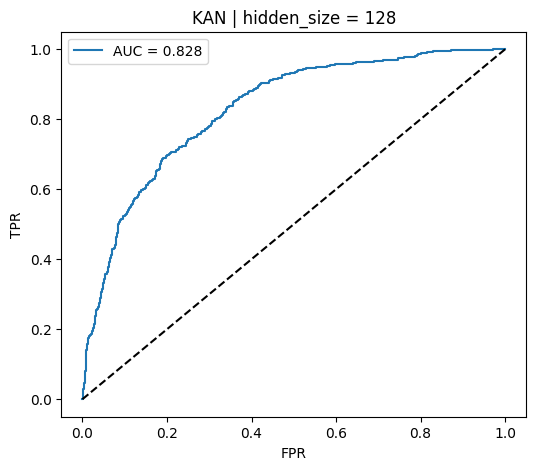

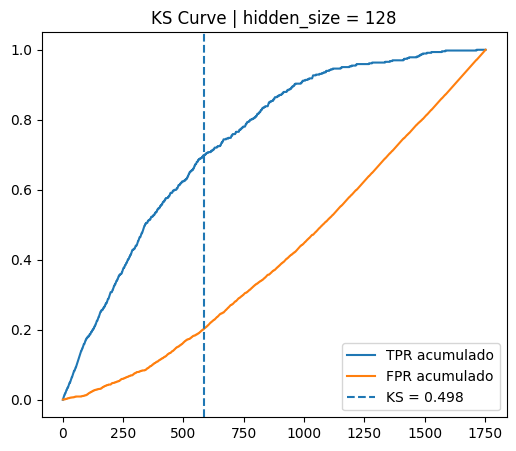

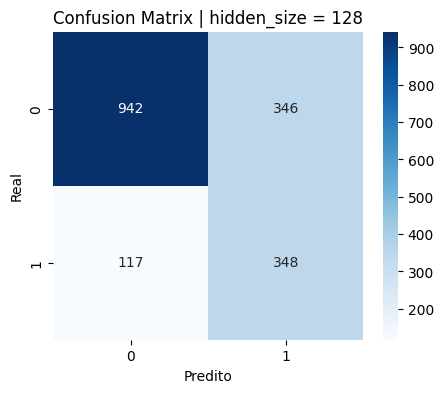

[I 2025-12-19 15:08:17,876] A new study created in memory with name: no-name-65d73f10-bd49-454c-8a52-d46128dd3da2



===== Experimento KAN | hidden_size = 256 =====


[I 2025-12-19 15:08:21,178] Trial 0 finished with value: 0.4037267080745342 and parameters: {'num_grids': 16, 'grid_min': -0.24066621027195545, 'grid_max': 1.5384377266307145, 'lr': 0.027023570326718316, 'weight_decay': 1.3276816955455302e-07}. Best is trial 0 with value: 0.4037267080745342.
[I 2025-12-19 15:08:24,098] Trial 1 finished with value: 0.49922360248447206 and parameters: {'num_grids': 16, 'grid_min': -1.3230524503405627, 'grid_max': 2.539238515011085, 'lr': 0.003199342720603128, 'weight_decay': 2.082246344396237e-07}. Best is trial 1 with value: 0.49922360248447206.
[I 2025-12-19 15:08:26,398] Trial 2 finished with value: 0.48136645962732916 and parameters: {'num_grids': 11, 'grid_min': -0.1143038068229334, 'grid_max': 2.4384397492683827, 'lr': 0.002027189712293401, 'weight_decay': 0.0007282824832652096}. Best is trial 1 with value: 0.49922360248447206.
[I 2025-12-19 15:08:26,937] Trial 3 finished with value: 0.07453416149068326 and parameters: {'num_grids': 10, 'grid_min':

Ep 001 | train_loss 0.8840 | val_loss 0.5864 | val_auc 0.8432 | val_ks 0.5373 | prec 0.829 | rec 0.539 | f1 0.653
Ep 002 | train_loss 0.5652 | val_loss 0.5337 | val_auc 0.8440 | val_ks 0.5528 | prec 0.797 | rec 0.639 | f1 0.709
Ep 003 | train_loss 0.5057 | val_loss 0.4971 | val_auc 0.8473 | val_ks 0.5543 | prec 0.779 | rec 0.761 | f1 0.770
Ep 004 | train_loss 0.5791 | val_loss 0.5487 | val_auc 0.8300 | val_ks 0.5186 | prec 0.799 | rec 0.591 | f1 0.679
Ep 005 | train_loss 0.4895 | val_loss 0.5194 | val_auc 0.8311 | val_ks 0.5411 | prec 0.771 | rec 0.730 | f1 0.750
Ep 006 | train_loss 0.4929 | val_loss 0.7585 | val_auc 0.8392 | val_ks 0.5443 | prec 0.862 | rec 0.387 | f1 0.534
Ep 007 | train_loss 0.4697 | val_loss 0.5423 | val_auc 0.8164 | val_ks 0.5062 | prec 0.755 | rec 0.702 | f1 0.727
Ep 008 | train_loss 0.5056 | val_loss 0.6705 | val_auc 0.8078 | val_ks 0.4915 | prec 0.624 | rec 0.929 | f1 0.746
Ep 009 | train_loss 0.4639 | val_loss 0.8202 | val_auc 0.8176 | val_ks 0.4829 | prec 0.8

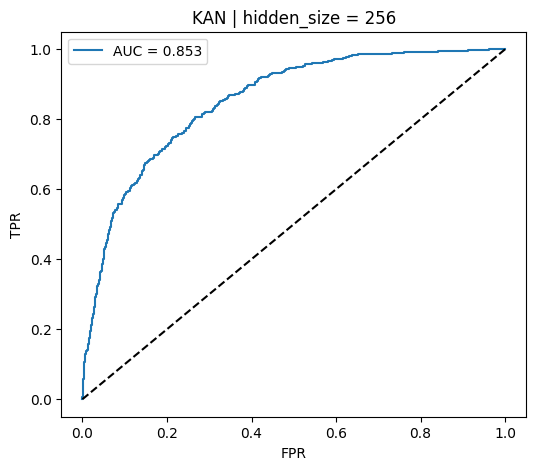

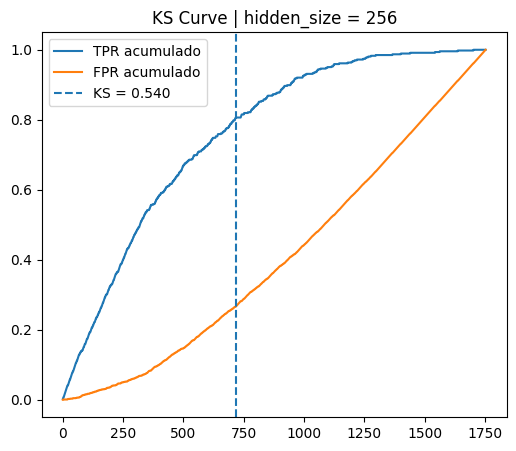

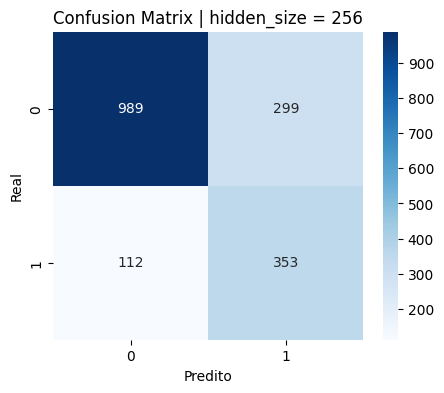

In [ ]:
HIDDEN_SIZES = [16, 32, 64, 128, 256]
summary = []

for hidden_size in HIDDEN_SIZES:

    print(f"\n===== Experimento KAN | hidden_size = {hidden_size} =====")

    # ─── 1. FIXA PARÂMETRO ─────────────────────────────
    fixed_params = {
        "n_layers": 1,                 # controla para isolar hidden_size
        "hidden_size_0": hidden_size
    }

    # ─── 2. OPTUNA ─────────────────────────────────────
    study = optuna.create_study(direction="maximize")
    study.optimize(
        objective_factory(
            experiment_name=f"KAN_hidden_{hidden_size}",
            fixed_params=fixed_params
        ),
        n_trials=15
    )

    best_params = {**fixed_params, **study.best_params}

    # ─── 3. RECONSTRÓI MODELO FINAL ────────────────────
    input_dim = X_train_over.shape[1]

    layers = [
        input_dim,
        hidden_size,
        1
    ]

    model = FastKAN(
        layers_hidden=layers,
        num_grids=best_params["num_grids"],
        grid_min=best_params["grid_min"],
        grid_max=best_params["grid_max"]
    )

    # ─── 4. TREINO FINAL COMPLETO ──────────────────────
    model, history, test_metrics = train_fastkan(
        model,
        train_dl,
        val_dl,
        test_dl,
        device="cuda",
        epochs=40,
        lr=best_params["lr"],
        weight_decay=best_params["weight_decay"],
        patience=8
    )

    y_true = test_metrics["y_true"]
    y_score = test_metrics["y_score"]

    # ─── 5. GRÁFICOS ───────────────────────────────────
    auc_score = plot_roc_curve(
        y_true,
        y_score,
        title=f"KAN | hidden_size = {hidden_size}"
    )

    ks_score = ks_curve(
        y_true,
        y_score,
        title=f"KS Curve | hidden_size = {hidden_size}"
    )

    plot_confusion(
        y_true,
        y_score,
        title=f"Confusion Matrix | hidden_size = {hidden_size}"
    )

    # ─── 6. SUMMARY ────────────────────────────────────
    summary.append({
        "hidden_size": hidden_size,
        "ks": ks_score,
        "auc": auc_score
    })


In [ ]:
summary_df = pd.DataFrame(summary)
summary_df

,hidden_size,ks,auc
0,16,0.554294,0.851763
1,32,0.546888,0.859297
2,64,0.545514,0.855754
3,128,0.497838,0.828490
4,256,0.540147,0.852546
